# Advantages in International Football

## Project Purpose

The purpose of this project is to explore how **FIFA ranking**, **population size**, and **match location** (Home / Away / Neutral ground) affect the outcome of international football matches.  
We aim to investigate whether there are measurable advantages associated with:

- Playing at home
- Having a larger population
- Holding a higher FIFA ranking

We will analyze how these factors influence:

- Win percentage
- Average points per match
- Goal difference

---

## Data Overview

Our analysis is based on **three datasets** that we have combined:

- **International matches** dataset (since 1992)
- **Country population** data
- **FIFA ranking** data at the time of each match

We have created **four versions** of the combined dataset:

1. **Original data** (full dataset)
2. **Without friendlies** (only competitive matches)
3. **Without neutral matches** (only matches played at home or away)
4. **Without friendlies and neutral matches** (pure competitive home/away games)

---

## Course of Action

1. **Data Cleaning**  
   Remove rows with any missing values to ensure high-quality input.

2. **Data Splitting**  
   Create the four dataset versions for comparison purposes.

3. **Unsupervised Learning**  
   Use clustering techniques (e.g., DBSCAN, PCA) to identify outliers and gain a better structural understanding of the data.

4. **Statistical Analysis**  
   Analyze basic statistics to assess:
   - Whether a home advantage exists
   - If the advantage varies between datasets

5. **Supervised Learning Models**  
   Build predictive models to forecast match outcomes based on match location, population, and FIFA ranking:
   - **Linear Regression** (predict points earned)
   - **Random Forest Regression** (predict points earned)
   - **Logistic Regression** (predict win vs non-win)

6. **Conclusions**  
   Summarize findings, focusing on:
   - The existence and strength of home advantage
   - The predictive power of population and ranking differences

---


In the making of this project we have used an AI-tool (ChatGPT) to help improve our code base, writing comments, general bug fixing, and used as a partner for discussing ideas and results. We also used AI to help with the comments throughout the notebook.

# Imports  
Loads libraries for data manipulation, visualization, statistics & ML.

# File Paths  
Defines paths to the four CSV files.

# Load Data  
Reads each CSV into a pandas DataFrame.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import statsmodels.api as sm
from IPython.display import display

from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    accuracy_score,
    confusion_matrix,
    classification_report
)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN


populationCsvPath = 'CsvFilesExam/world_population.csv'
resultsCsvPath = 'CsvFilesExam/results.csv'
rankingCsvPath = 'CsvFilesExam/fifa_mens_rank.csv'
mergedDataCsvPath = 'CsvFilesExam/merged_data.csv'

populationData = pd.read_csv(populationCsvPath)
resultsData = pd.read_csv(resultsCsvPath)
rankingData = pd.read_csv(rankingCsvPath)



This section is our primary functions for creating our datasets.

# load_or_create_merged_data  
Loads cached merged dataset if available, otherwise reads raw files, merges them, saves to CSV, and returns it.

# add_population_and_ranking_to_results  
Combines match results with nearest‐year population and latest pre‐match FIFA rankings, then drops helper columns.

# remove_nan_population_rows  
Removes any matches missing home/away population data.

# remove_nan_fifa_ranking_rows  
Removes any matches missing home/away FIFA ranking data.


In [2]:
def load_or_create_merged_data(results_path, population_path, ranking_path, merged_output_path):
    """
    Loads merged data if it exists, otherwise creates it and saves to CSV.
    """
    if os.path.exists(merged_output_path):
        print(f"Loading existing merged dataset from {merged_output_path}...")
        mergedData = pd.read_csv(merged_output_path)
        
        mergedData['date'] = pd.to_datetime(mergedData['date'])
        
    else:
        print("Merged dataset not found, creating merged data...")
        
        # Load original data
        resultsData = pd.read_csv(results_path)
        populationData = pd.read_csv(population_path)
        rankingData = pd.read_csv(ranking_path)
        
        # Merge
        mergedData = add_population_and_ranking_to_results(resultsData, populationData, rankingData)
        
        # Save merged dataset
        mergedData.to_csv(merged_output_path, index=False)
        print(f"Merged dataset created and saved to {merged_output_path}")
    
    return mergedData

def add_population_and_ranking_to_results(results: pd.DataFrame, 
                                          world_population: pd.DataFrame, 
                                          ranking_data: pd.DataFrame) -> pd.DataFrame:
    # Parse dates
    results['date'] = pd.to_datetime(results['date'])
    ranking_data['date'] = pd.to_datetime(ranking_data['date'])

    # Extract year from match date
    results['year'] = results['date'].dt.year

    # Rename country column for easier matching
    world_population = world_population.rename(columns={'Country/Territory': 'Country'})

    # Define available years in world_population
    available_years = [2022, 2020, 2015, 2010, 2000, 1990, 1980, 1970]

    # Helper function to find best available year
    def closest_year(match_year):
        for y in sorted(available_years, reverse=True):
            if match_year >= y:
                return y
        return min(available_years)

    # Apply closest year
    results['population_year'] = results['year'].apply(closest_year)

    # Prepare population data
    pop_data = {}
    for _, row in world_population.iterrows():
        pop_data[row['Country']] = {year: row.get(f'{year} Population') for year in available_years}

    # Function to get population
    def get_population(team, year):
        country_data = pop_data.get(team)
        if country_data:
            return country_data.get(year)
        return None

    results['home_population'] = results.apply(lambda row: get_population(row['home_team'], row['population_year']), axis=1)
    results['away_population'] = results.apply(lambda row: get_population(row['away_team'], row['population_year']), axis=1)

    # ---------------------------------------
    # Add home_ranking and away_ranking
    # ---------------------------------------

    # Prepare: for easier lookup, sort ranking_data
    ranking_data = ranking_data.sort_values('date')

    def find_latest_ranking(team, match_date):
        team_rankings = ranking_data[ranking_data['team'] == team]  # fixed!
        team_rankings = team_rankings[team_rankings['date'] <= match_date]
        if not team_rankings.empty:
            return team_rankings.iloc[-1]['rank']
        else:
            return None

    # Apply for home and away teams
    results['home_ranking'] = results.apply(lambda row: find_latest_ranking(row['home_team'], row['date']), axis=1)
    results['away_ranking'] = results.apply(lambda row: find_latest_ranking(row['away_team'], row['date']), axis=1)

    # Clean up helper columns
    results = results.drop(columns=['year', 'population_year'])

    return results


def remove_nan_population_rows(results: pd.DataFrame) -> pd.DataFrame:
    # Remove rows where home_population or away_population is NaN
    results = results.dropna(subset=['home_population', 'away_population'])
    return results

def remove_nan_fifa_ranking_rows(results: pd.DataFrame) -> pd.DataFrame:
    # Remove rows where home_population or away_population is NaN
    results = results.dropna(subset=['home_ranking', 'away_ranking'])
    return results    

  

In [3]:
mergedData = load_or_create_merged_data(resultsCsvPath, populationCsvPath, rankingCsvPath, mergedDataCsvPath)
print(mergedData.describe())

Loading existing merged dataset from CsvFilesExam/merged_data.csv...
                                date    home_score    away_score  \
count                          48207  48207.000000  48207.000000   
mean   1993-07-18 08:20:38.459144832      1.759890      1.182048   
min              1872-11-30 00:00:00      0.000000      0.000000   
25%              1979-11-01 12:00:00      1.000000      0.000000   
50%              2000-01-24 00:00:00      1.000000      1.000000   
75%              2012-09-07 00:00:00      2.000000      2.000000   
max              2025-03-25 00:00:00     31.000000     21.000000   
std                              NaN      1.774537      1.401071   

       home_population  away_population  home_ranking  away_ranking  
count     4.373400e+04     4.347100e+04  36139.000000  36141.000000  
mean      3.251719e+07     2.721746e+07     80.960486     83.264077  
min       5.640000e+02     5.960000e+02      1.000000      1.000000  
25%       2.953750e+06     2.943356e+0

# The first of our two unsupervised learning models used
# PCA on mergedData  
1. Clean NaNs & compute difference features (population, ranking, goals)  
2. Scale features and run PCA (2 components)  
3. Plot PC1 vs PC2 scatter and print explained variance  


7977     -0.023928
7979    -10.130379
7982    -17.003040
7984     30.559612
7986    -21.855459
           ...    
48201     1.946934
48202     3.603990
48203   -19.358671
48205   -10.461337
48206     0.573992
Name: population_difference, Length: 29383, dtype: float64


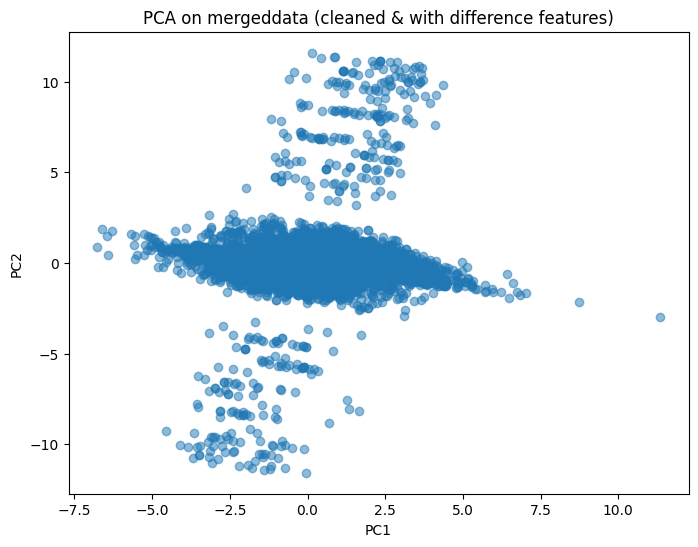

Explained variance ratio: [0.50623184 0.32652562]


In [4]:
# ─────────────── PCA on mergeddata  ───────────────

# 1. Initialize
scaler = StandardScaler()
pca    = PCA(n_components=2, random_state=42)

# 2. Clean NaNs
mergedData = remove_nan_population_rows(mergedData).copy()
mergedData = remove_nan_fifa_ranking_rows(mergedData).copy()

# 3. Difference features
mergedData['population_difference'] = (mergedData['home_population'] - mergedData['away_population']) / 1000000
mergedData['ranking_difference']    = mergedData['away_ranking']  - mergedData['home_ranking']
mergedData['home_goal_difference']    = mergedData['home_score']  - mergedData['away_score']

print(mergedData['population_difference'])


# 4. Feature matrix & scaling
feature_cols = [
    'population_difference', 'ranking_difference','home_goal_difference'
]
X = mergedData[feature_cols]
X_scaled = scaler.fit_transform(X)  

# 5. PCA and plot
X_pca = pca.fit_transform(X_scaled) 
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.title("PCA on mergeddata (cleaned & with difference features)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# 6. Explained variance
print("Explained variance ratio:", pca.explained_variance_ratio_)


# K-Means Clustering on Difference Features  
- Scale features and evaluate inertia & silhouette for k=2–10  
- Plot elbow & silhouette curves to pick best k  
- Fit K-Means with selected k and assign cluster labels  
- Print average silhouette score and mean profiles per cluster  
- Visualize clusters on PCA 2D embedding  


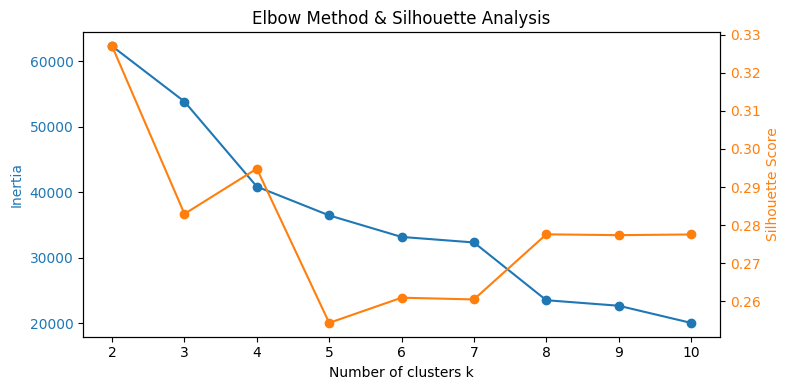

Average silhouette score (k=4): 0.295
         population_difference  ranking_difference  home_goal_difference
cluster                                                                 
0                        17.10               68.16                  3.26
1                       -32.85              -60.98                 -1.41
2                         5.88                9.85                  0.49
3                       999.55                5.86                  0.21


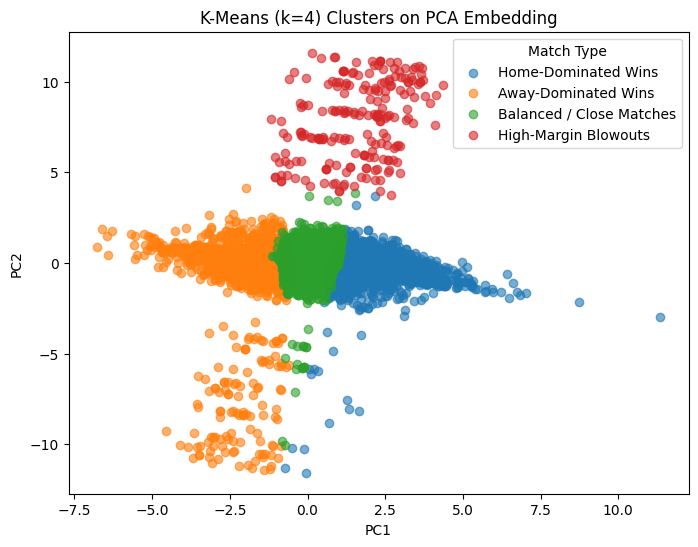

In [5]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 1. Assemble feature matrix & scale
feature_cols = [
    'population_difference',
    'ranking_difference',
    'home_goal_difference'
]
X        = mergedData[feature_cols]
X_scaled = scaler.transform(X)

# 2. Compute inertia and silhouette for k = 2…10
Ks         = range(2, 11)
inertias   = []
sil_scores = []

for k in Ks:
    km = KMeans(n_clusters=k, random_state=42).fit(X_scaled)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, km.labels_))

# 3. Plot both metrics on twin axes
fig, ax1 = plt.subplots(figsize=(8, 4))

ax1.plot(Ks, inertias, '-o', label='Inertia')
ax1.set_xlabel('Number of clusters k')
ax1.set_ylabel('Inertia', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_xticks(Ks)

ax2 = ax1.twinx()
ax2.plot(Ks, sil_scores, '-o', color='tab:orange', label='Silhouette')
ax2.set_ylabel('Silhouette Score', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

plt.title('Elbow Method & Silhouette Analysis')
fig.tight_layout()
plt.show()

# 4. Amount of clusters - chosen based on silhouette and elbow
best_k = 4   

# 5. Fit K-Means with the selected k
km     = KMeans(n_clusters=best_k, random_state=42).fit(X_scaled)
labels = km.labels_
mergedData['cluster'] = labels

# 6. Print the average silhouette for the chosen k
print(f"Average silhouette score (k={best_k}):",
      silhouette_score(X_scaled, labels).round(3))

# 7. Profile each cluster in original feature space
cluster_profiles = mergedData.groupby('cluster')[
    ['population_difference', 'ranking_difference', 'home_goal_difference']
].mean().round(2)
print(cluster_profiles)

# 8. Map each cluster ID to a descriptive match type
cluster_names = {
    0: 'Home-Dominated Wins',
    1: 'Away-Dominated Wins',
    2: 'Balanced / Close Matches',
    3: 'High-Margin Blowouts'
}

# 9. Project to 2D using your existing PCA transformer
X_pca = pca.transform(X_scaled)

# 10. Scatter plot, coloring by descriptive labels
plt.figure(figsize=(8, 6))
for cid, cname in cluster_names.items():
    mask = labels == cid
    plt.scatter(
        X_pca[mask, 0],
        X_pca[mask, 1],
        label=cname,
        alpha=0.6
    )

plt.title(f"K-Means (k={best_k}) Clusters on PCA Embedding")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Match Type")
plt.show()


# Re-cluster Without Blowouts  
Filters out high-margin blowouts, then scales features and evaluates inertia & silhouette for k=2–10. Picks best k, fits K-Means, prints silhouette & cluster profiles, and visualizes on PCA embedding.  

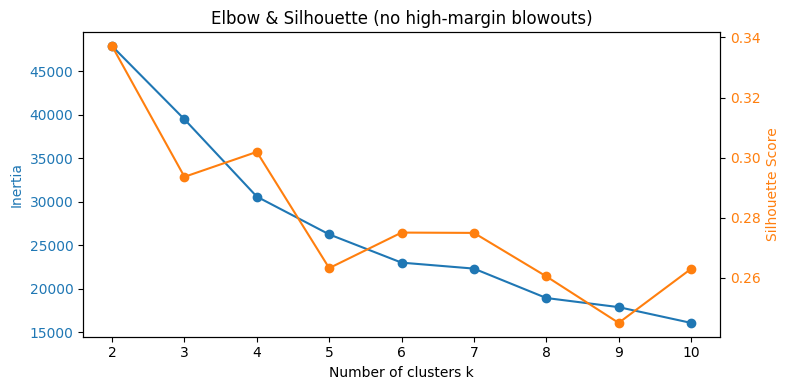

Average silhouette score (k=4): 0.302
          population_difference  ranking_difference  home_goal_difference
cluster2                                                                 
0                        -16.10              -60.78                 -1.43
1                          6.35               10.66                  0.52
2                         19.21               68.92                  3.31
3                       -966.30               -8.27                  0.85


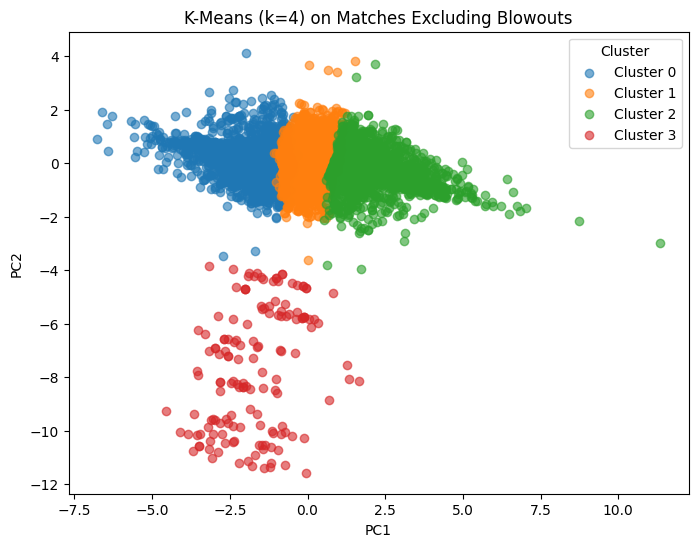

In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 1. Filter out high‐margin blowouts (cluster ID = 3)
filtered = mergedData[mergedData['cluster'] != 3].copy()

# 2. Assemble feature matrix & scale
feature_cols = [
    'population_difference',
    'ranking_difference',
    'home_goal_difference'
]
X2        = filtered[feature_cols]
X2_scaled = scaler.transform(X2)   # reuse your existing scaler

# 3. Compute inertia & silhouette for k = 2…10 on filtered data
Ks2        = range(2, 11)
inertias2  = []
sil_scores2 = []

for k in Ks2:
    km = KMeans(n_clusters=k, random_state=42).fit(X2_scaled)
    inertias2.append(km.inertia_)
    sil_scores2.append(silhouette_score(X2_scaled, km.labels_))

# 4. Plot both metrics
fig, ax1 = plt.subplots(figsize=(8, 4))

ax1.plot(Ks2, inertias2, '-o', label='Inertia')
ax1.set_xlabel('Number of clusters k')
ax1.set_ylabel('Inertia', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_xticks(Ks2)

ax2 = ax1.twinx()
ax2.plot(Ks2, sil_scores2, '-o', color='tab:orange', label='Silhouette')
ax2.set_ylabel('Silhouette Score', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

plt.title('Elbow & Silhouette (no high‐margin blowouts)')
fig.tight_layout()
plt.show()

# 5. Amount of clusters - chosen based on silhouette and elbow
best_k2 = 4  

# 6. Fit K-Means with the selected k and report final silhouette
km2      = KMeans(n_clusters=best_k2, random_state=42).fit(X2_scaled)
labels2  = km2.labels_
filtered['cluster2'] = labels2

print(f"Average silhouette score (k={best_k2}):",
      silhouette_score(X2_scaled, labels2).round(3))

# 7. Profile each new cluster in original feature space
profiles2 = filtered.groupby('cluster2')[feature_cols].mean().round(2)
print(profiles2)

# 8. Scatter plot of the clusters on your PCA embedding
X2_pca = pca.transform(X2_scaled)

plt.figure(figsize=(8, 6))
for cid in range(best_k2):
    mask = labels2 == cid
    plt.scatter(
        X2_pca[mask, 0],
        X2_pca[mask, 1],
        label=f'Cluster {cid}',
        alpha=0.6
    )
plt.title(f"K-Means (k={best_k2}) on Matches Excluding Blowouts")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.show()


# Outlier Removal  
Filters out the remaining “outlier” cluster (cluster2 == 3) and rescales features.

# Elbow & Silhouette Analysis (k=2–6)  
Computes and plots inertia and silhouette to pick the optimal k on the cleaned data.

# Final K-Means (k=3)  
Fits K-Means with k=3, prints average silhouette score, and shows cluster feature profiles.

# Visualization on PCA Embedding  
Plots the three clusters (Balanced, Home-Moderate, Away-Moderate) in the existing 2D PCA space.


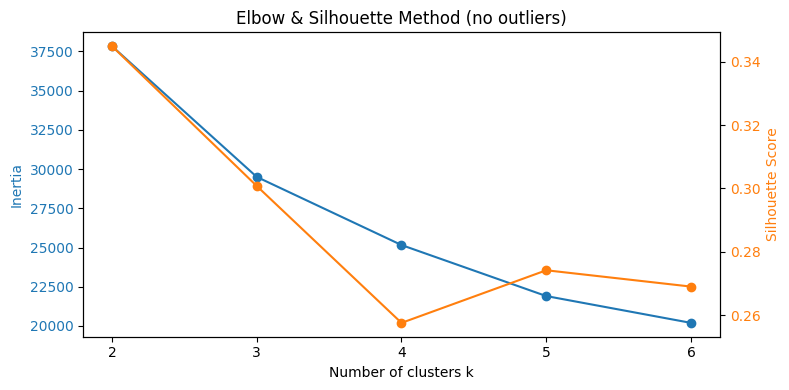

Average silhouette score (k=3): 0.301
          population_difference  ranking_difference  home_goal_difference
cluster3                                                                 
0                          6.43               10.85                  0.53
1                        -16.02              -60.45                 -1.42
2                         19.24               69.17                  3.32


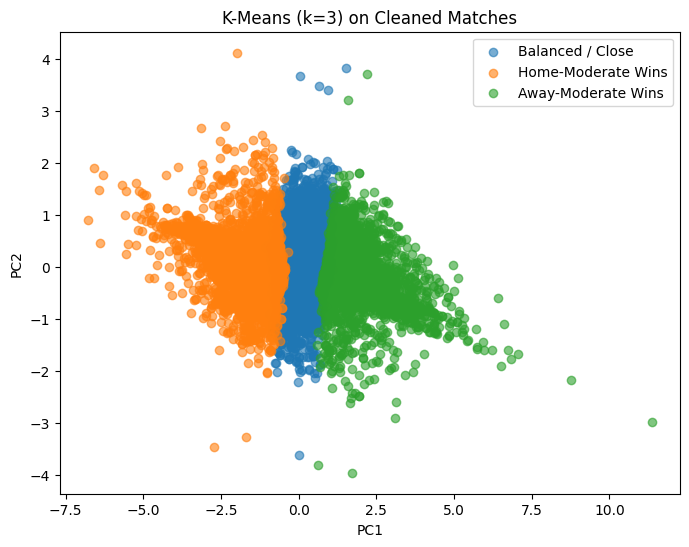

In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 1. Remove the “outlier” cluster (cluster2 == 3)
clean = filtered[filtered['cluster2'] != 3].copy()

# 2. Re‐assemble & scale
feature_cols = ['population_difference','ranking_difference','home_goal_difference']
Xc        = clean[feature_cols]
Xc_scaled = scaler.transform(Xc)

# 3. Compute inertia & silhouette for k = 2…6 on the cleaned set
Ks        = range(2, 7)
inertias  = []
sil_scores = []
for k in Ks:
    km = KMeans(n_clusters=k, random_state=42).fit(Xc_scaled)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(Xc_scaled, km.labels_))

# 4. Plot both metrics on twin axes
fig, ax1 = plt.subplots(figsize=(8, 4))

ax1.plot(Ks, inertias, '-o', label='Inertia')
ax1.set_xlabel('Number of clusters k')
ax1.set_ylabel('Inertia', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_xticks(Ks)

ax2 = ax1.twinx()
ax2.plot(Ks, sil_scores, '-o', color='tab:orange', label='Silhouette Score')
ax2.set_ylabel('Silhouette Score', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

plt.title('Elbow & Silhouette Method (no outliers)')
fig.tight_layout()
plt.show()

# 5.  Amount of clusters - chosen based on silhouette and elbow
best_k = 3
km3    = KMeans(n_clusters=best_k, random_state=42).fit(Xc_scaled)
labels3 = km3.labels_
clean['cluster3'] = labels3

# 6. Print the final average silhouette
print(f"Average silhouette score (k={best_k}):",
      silhouette_score(Xc_scaled, labels3).round(3))

# 7. Profile the three clusters
print(clean.groupby('cluster3')[feature_cols].mean().round(2))

# 8. Scatter on your PCA embedding
Xc_pca = pca.transform(Xc_scaled)
plt.figure(figsize=(8,6))
names = {0:'Balanced / Close', 1:'Home-Moderate Wins', 2:'Away-Moderate Wins'}
for cid, name in names.items():
    mask = labels3 == cid
    plt.scatter(Xc_pca[mask,0], Xc_pca[mask,1], alpha=0.6, label=name)
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.title('K-Means (k=3) on Cleaned Matches')
plt.legend()
plt.show()


# Filter by Match Type & Venue  
- Copy cleaned dataset  
- Remove friendly matches  
- Remove neutral‐site matches  
- Remove both friendlies AND neutral matches  
- Print original & filtered dataset sizes  

In [8]:

mergedData = clean.copy()
# 1. Remove Friendlies
mergedData_no_friendlies = mergedData[mergedData['tournament'] != 'Friendly'].copy()

# 2. Remove Neutral Matches
mergedData_no_neutral = mergedData[mergedData['neutral'] == False].copy()

# 3. Remove Friendlies AND Neutral Matches
mergedData_no_friendlies_no_neutral = mergedData[
    (mergedData['tournament'] != 'Friendly') & (mergedData['neutral'] == False)].copy()

print(f"Original dataset size: {mergedData.shape[0]} matches")
print(f"Without Friendlies: {mergedData_no_friendlies.shape[0]} matches")
print(f"Without Neutral Matches: {mergedData_no_neutral.shape[0]} matches")
print(f"Without Friendlies AND Neutral Matches: {mergedData_no_friendlies_no_neutral.shape[0]} matches")


Original dataset size: 29027 matches
Without Friendlies: 18598 matches
Without Neutral Matches: 21329 matches
Without Friendlies AND Neutral Matches: 12705 matches


# determine_result  
Labels each match as 'home_win', 'away_win', or 'draw'.

# calculate_points  
Adds home_points/away_points (3/1/0) and prints average points per match.

# plot_home_advantage  
Plots a pie chart of outcomes and a histogram of home goal differences.

In [9]:
def determine_result(row):
    if row['home_score'] > row['away_score']:
        return 'home_win'
    elif row['home_score'] < row['away_score']:
        return 'away_win'
    else:
        return 'draw'
        
def calculate_points(results: pd.DataFrame) -> pd.DataFrame:
    def home_points(row):
        if row['outcome'] == 'home_win':
            return 3
        elif row['outcome'] == 'draw':
            return 1
        else:
            return 0

    def away_points(row):
        if row['outcome'] == 'away_win':
            return 3
        elif row['outcome'] == 'draw':
            return 1
        else:
            return 0

    results['home_points'] = results.apply(home_points, axis=1)
    results['away_points'] = results.apply(away_points, axis=1)

    average_home_points = results['home_points'].mean()
    average_away_points = results['away_points'].mean()

    print(f"Average points earned by home teams: {average_home_points:.2f} per match")
    print(f"Average points earned by away teams: {average_away_points:.2f} per match")

    return results

def plot_home_advantage(results: pd.DataFrame) -> None:
    """
    Plots a pie chart of match outcomes and a histogram of goal differences
    for home teams based on the provided results DataFrame.
    """
    # Pie chart of match outcomes
    results['outcome'].value_counts().plot(kind='pie', autopct='%1.1f%%')
    plt.title('Home Team Match Outcomes')
    plt.ylabel('')  # Remove y-axis label for cleaner pie chart
    plt.show()

    # Histogram of home team goal difference
    plt.hist(results['goal_difference'], bins=30, edgecolor='black')
    plt.title('Distribution of Home Team Goal Difference')
    plt.xlabel('Goal Difference (Home - Away)')
    plt.ylabel('Number of Matches')
    plt.show()
    

# Match outcomes in percentage

In [10]:
print("--- Original mergedData ---")
mergedData['outcome'] = mergedData.apply(determine_result, axis=1)
outcome_counts = mergedData['outcome'].value_counts(normalize=True) * 100
print(outcome_counts)

print("\n--- No Friendlies ---")
mergedData_no_friendlies['outcome'] = mergedData_no_friendlies.apply(determine_result, axis=1)
outcome_counts_no_friendlies = mergedData_no_friendlies['outcome'].value_counts(normalize=True) * 100
print(outcome_counts_no_friendlies)

print("\n--- No Neutral Matches ---")
mergedData_no_neutral['outcome'] = mergedData_no_neutral.apply(determine_result, axis=1)
outcome_counts_no_neutral = mergedData_no_neutral['outcome'].value_counts(normalize=True) * 100
print(outcome_counts_no_neutral)

print("\n--- No Friendlies and No Neutral Matches ---")
mergedData_no_friendlies_no_neutral['outcome'] = mergedData_no_friendlies_no_neutral.apply(determine_result, axis=1)
outcome_counts_no_friendlies_no_neutral = mergedData_no_friendlies_no_neutral['outcome'].value_counts(normalize=True) * 100
print(outcome_counts_no_friendlies_no_neutral)


--- Original mergedData ---
outcome
home_win    48.534123
away_win    27.405519
draw        24.060358
Name: proportion, dtype: float64

--- No Friendlies ---
outcome
home_win    49.344015
away_win    28.320249
draw        22.335735
Name: proportion, dtype: float64

--- No Neutral Matches ---
outcome
home_win    50.719677
away_win    25.303577
draw        23.976745
Name: proportion, dtype: float64

--- No Friendlies and No Neutral Matches ---
outcome
home_win    52.121212
away_win    25.879575
draw        21.999213
Name: proportion, dtype: float64


In [11]:
print("--- Original mergedData ---")
mergedData['goal_difference'] = mergedData['home_score'] - mergedData['away_score']
average_goal_difference = mergedData['goal_difference'].mean()
print(f"Average Home Goal Difference: {average_goal_difference:.2f}")

print("\n--- No Friendlies ---")
mergedData_no_friendlies['goal_difference'] = mergedData_no_friendlies['home_score'] - mergedData_no_friendlies['away_score']
average_goal_difference_no_friendlies = mergedData_no_friendlies['goal_difference'].mean()
print(f"Average Home Goal Difference (No Friendlies): {average_goal_difference_no_friendlies:.2f}")

print("\n--- No Neutral Matches ---")
mergedData_no_neutral['goal_difference'] = mergedData_no_neutral['home_score'] - mergedData_no_neutral['away_score']
average_goal_difference_no_neutral = mergedData_no_neutral['goal_difference'].mean()
print(f"Average Home Goal Difference (No Neutral Matches): {average_goal_difference_no_neutral:.2f}")

print("\n--- No Friendlies and No Neutral Matches ---")
mergedData_no_friendlies_no_neutral['goal_difference'] = mergedData_no_friendlies_no_neutral['home_score'] - mergedData_no_friendlies_no_neutral['away_score']
average_goal_difference_no_friendlies_no_neutral = mergedData_no_friendlies_no_neutral['goal_difference'].mean()
print(f"Average Home Goal Difference (No Friendlies & No Neutral Matches): {average_goal_difference_no_friendlies_no_neutral:.2f}")


--- Original mergedData ---
Average Home Goal Difference: 0.56

--- No Friendlies ---
Average Home Goal Difference (No Friendlies): 0.59

--- No Neutral Matches ---
Average Home Goal Difference (No Neutral Matches): 0.67

--- No Friendlies and No Neutral Matches ---
Average Home Goal Difference (No Friendlies & No Neutral Matches): 0.74


In [12]:
# Apply determine_result and calculate_points properly for all datasets
print("--- Original mergedData ---")
mergedData['outcome'] = mergedData.apply(determine_result, axis=1)
mergedData = calculate_points(mergedData)

print("\n--- No Friendlies ---")
mergedData_no_friendlies['outcome'] = mergedData_no_friendlies.apply(determine_result, axis=1)
mergedData_no_friendlies = calculate_points(mergedData_no_friendlies)

print("\n--- No Neutral Matches ---")
mergedData_no_neutral['outcome'] = mergedData_no_neutral.apply(determine_result, axis=1)
mergedData_no_neutral = calculate_points(mergedData_no_neutral)

print("\n--- No Friendlies and No Neutral Matches ---")
mergedData_no_friendlies_no_neutral['outcome'] = mergedData_no_friendlies_no_neutral.apply(determine_result, axis=1)
mergedData_no_friendlies_no_neutral = calculate_points(mergedData_no_friendlies_no_neutral)


--- Original mergedData ---
Average points earned by home teams: 1.70 per match
Average points earned by away teams: 1.06 per match

--- No Friendlies ---
Average points earned by home teams: 1.70 per match
Average points earned by away teams: 1.07 per match

--- No Neutral Matches ---
Average points earned by home teams: 1.76 per match
Average points earned by away teams: 1.00 per match

--- No Friendlies and No Neutral Matches ---
Average points earned by home teams: 1.78 per match
Average points earned by away teams: 1.00 per match


--- Original mergedData ---


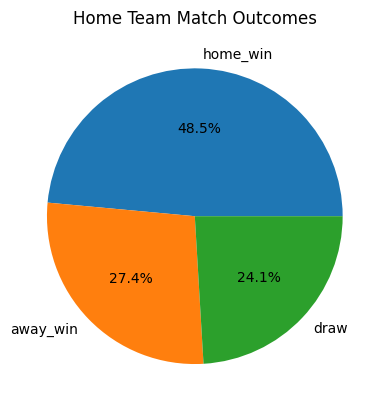

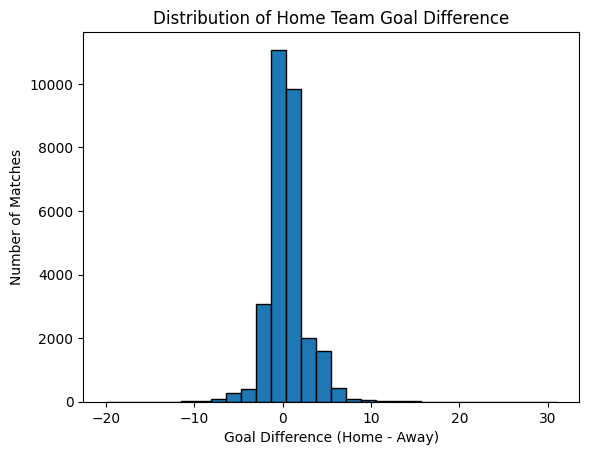


--- No Friendlies ---


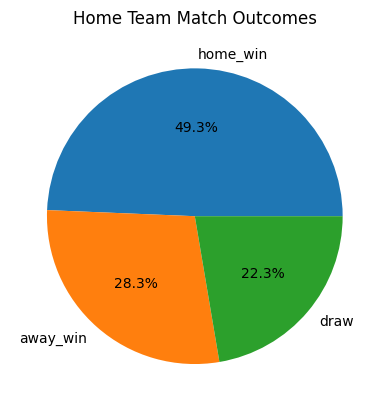

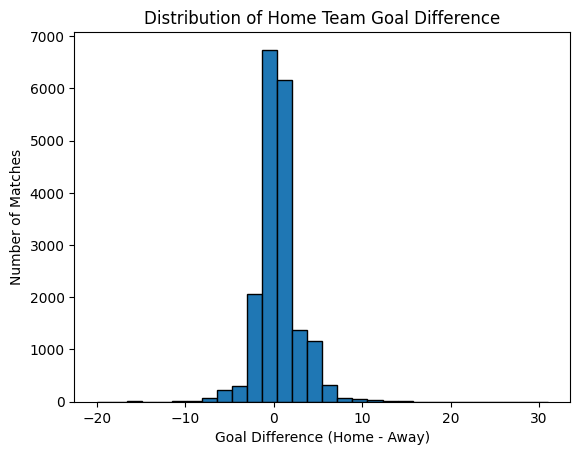


--- No Neutral Matches ---


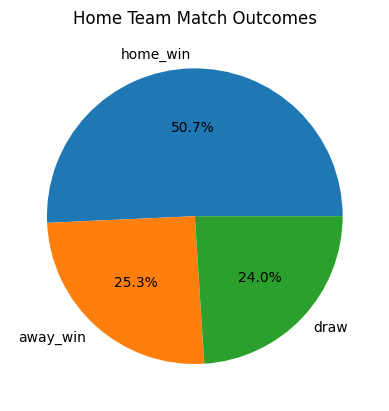

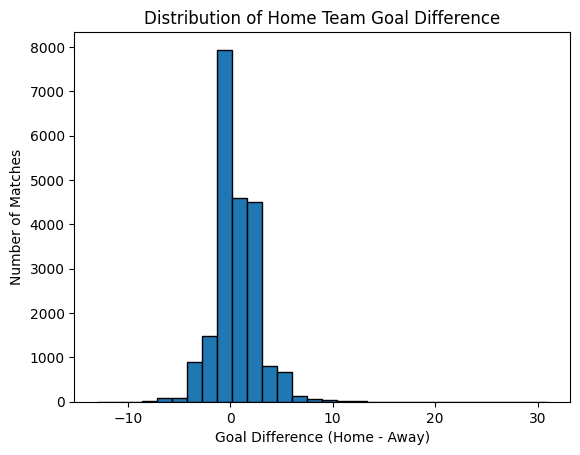


--- No Friendlies and No Neutral Matches ---


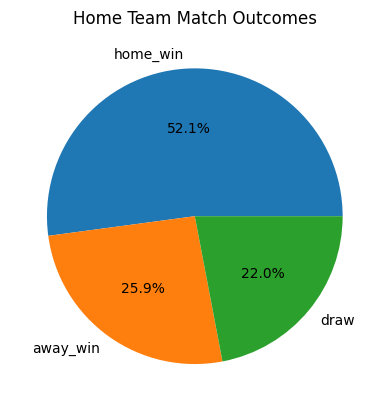

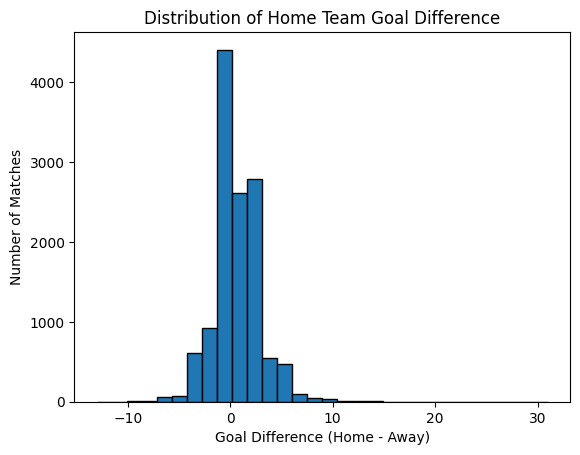

In [13]:
print("--- Original mergedData ---")
plot_home_advantage(mergedData)

print("\n--- No Friendlies ---")
plot_home_advantage(mergedData_no_friendlies)

print("\n--- No Neutral Matches ---")
plot_home_advantage(mergedData_no_neutral)

print("\n--- No Friendlies and No Neutral Matches ---")
plot_home_advantage(mergedData_no_friendlies_no_neutral)


# Partial conclusion on statistics
The data suggest the existence of a home advantage, which becomes more pronounced in competitive matches played on non-neutral grounds.
In such matches, there is an increase in home wins, points accumulated, and goal difference in favor of the home team.
Additionally, the likelihood of a draw appears to decrease slightly when the match is competitive.

### Population Impact Analysis
# analyze_population_impact  
Prepares population difference vs. home points, fits a linear regression, prints coefficient, intercept, R² & p-value, and plots the fit.

# analyze_goal_difference_impact  
Prepares population difference vs. home goal difference, fits a linear regression, prints model stats (coef, intercept, R² & p-value), and plots the regression line.

In [14]:
def analyze_population_impact(results: pd.DataFrame, scale_population: bool = True):

    # 1. Prepare data
    X = results[['population_difference']]
    y = results['home_points']

    # 2. Train model
    model = LinearRegression()
    model.fit(X, y)

    # 3. Statsmodels for p-value
    X_with_const = sm.add_constant(X)
    sm_model = sm.OLS(y, X_with_const).fit()

    # 4. Print model info
    print("Linear Regression Model:")
    print(f"Home Points = {model.coef_[0]:.6f} * Population Difference + {model.intercept_:.6f}")
    print(f"R² Score: {model.score(X, y):.4f}")
    print(f"P-value for Population Difference: {sm_model.pvalues['population_difference']:.6f}")

    # 5. Impact conclusion
    print("\nImpact Conclusion:")
    if scale_population:
        print(f"For every 1 million more people at home vs away, home teams earn {model.coef_[0]:.8f} additional points on average.")
    else:
        print(f"For every 1 person more, home teams earn {model.coef_[0]:.8f} additional points on average.")

    # 6. Plot
    predictions = model.predict(X)
    plt.scatter(X, y, alpha=0.3, label="Actual matches")
    plt.plot(X, predictions, color='red', label="Regression Line")
    plt.xlabel('Population Difference (Home - Away) [Millions]' if scale_population else 'Population Difference')
    plt.ylabel('Home Points')
    plt.title('Impact of Population Difference on Home Points')
    plt.legend()
    plt.show()

    return model

def analyze_goal_difference_impact(results: pd.DataFrame, scale_population: bool = True):
    

    # 1. Prepare data
    X = results[['population_difference']]
    y = results['home_goal_difference']

    # 2. Train linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # 3. Statsmodels OLS for detailed statistics
    X_with_const = sm.add_constant(X)
    sm_model = sm.OLS(y, X_with_const).fit()

    # 4. Print model information
    print("Linear Regression Model:")
    print(f"Home Goal Difference = {model.coef_[0]:.6f} * Population Difference + {model.intercept_:.6f}")
    print(f"R² Score: {model.score(X, y):.4f}")
    print(f"P-value for Population Difference: {sm_model.pvalues['population_difference']:.6f}")

    # 5. Impact conclusion
    print("\nImpact Conclusion:")
    if scale_population:
        print(f"For every 1 million more people at home vs away, home teams score {model.coef_[0]:.8f} more goals on average.")
    else:
        print(f"For every 1 person more, home teams score {model.coef_[0]:.8f} more goals on average.")

    # 6. Plot
    predictions = model.predict(X)
    plt.scatter(X, y, alpha=0.3, label="Actual matches")
    plt.plot(X, predictions, color='red', label="Regression Line")
    plt.xlabel('Population Difference (Home - Away) [Millions]' if scale_population else 'Population Difference')
    plt.ylabel('Home Goal Difference')
    plt.title('Impact of Population Difference on Home Goal Difference')
    plt.legend()
    plt.show()

    return model    

------------------Points DIFFERENCE______________________________
--- Original mergedData ---
Linear Regression Model:
Home Points = 0.003867 * Population Difference + 1.685393
R² Score: 0.0222
P-value for Population Difference: 0.000000

Impact Conclusion:
For every 1 million more people at home vs away, home teams earn 0.00386726 additional points on average.


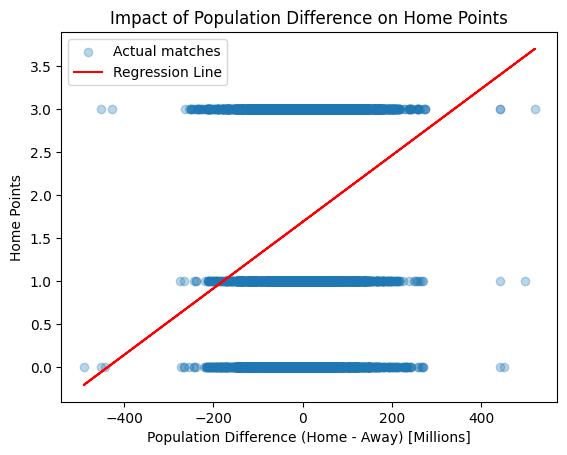


--- No Friendlies ---
Linear Regression Model:
Home Points = 0.003892 * Population Difference + 1.693675
R² Score: 0.0227
P-value for Population Difference: 0.000000

Impact Conclusion:
For every 1 million more people at home vs away, home teams earn 0.00389231 additional points on average.


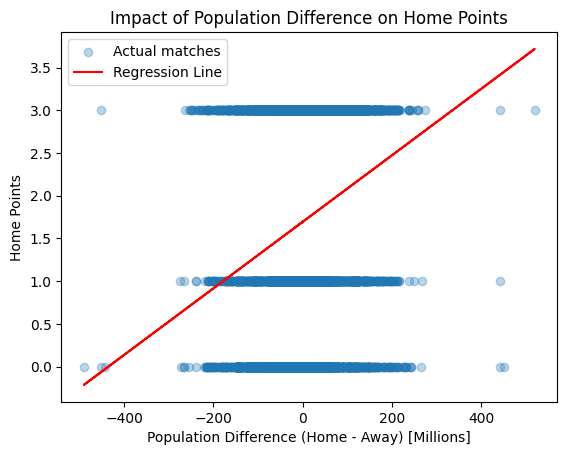


--- No Neutral Matches ---
Linear Regression Model:
Home Points = 0.004577 * Population Difference + 1.752358
R² Score: 0.0285
P-value for Population Difference: 0.000000

Impact Conclusion:
For every 1 million more people at home vs away, home teams earn 0.00457740 additional points on average.


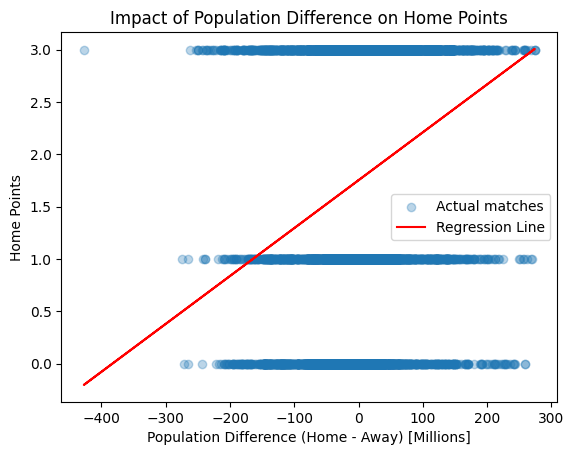


--- No Friendlies and No Neutral Matches ---
Linear Regression Model:
Home Points = 0.004884 * Population Difference + 1.774885
R² Score: 0.0325
P-value for Population Difference: 0.000000

Impact Conclusion:
For every 1 million more people at home vs away, home teams earn 0.00488387 additional points on average.


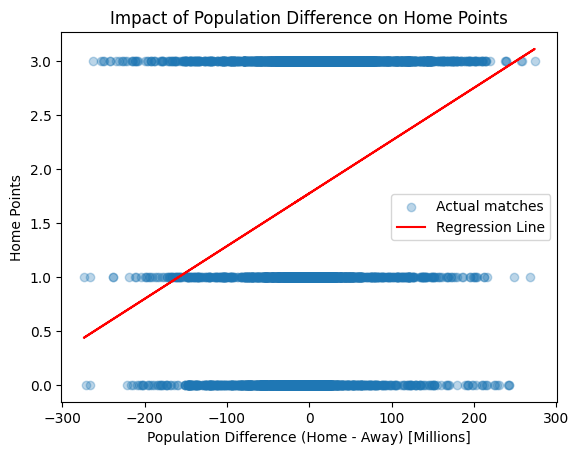

------------------GOAL DIFFERENCE______________________________
--- Original mergedData ---
Linear Regression Model:
Home Goal Difference = 0.006655 * Population Difference + 0.536252
R² Score: 0.0229
P-value for Population Difference: 0.000000

Impact Conclusion:
For every 1 million more people at home vs away, home teams score 0.00665523 more goals on average.


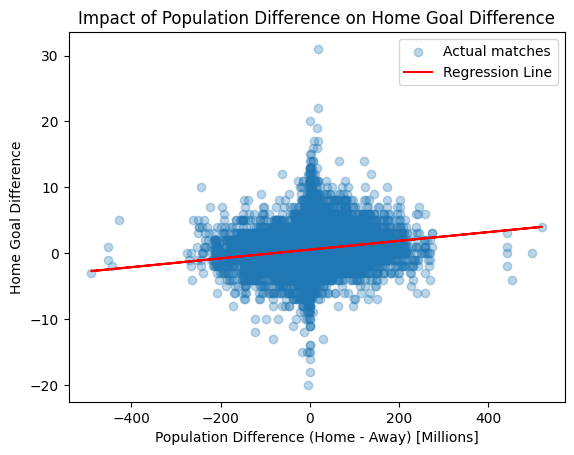


--- No Friendlies ---
Linear Regression Model:
Home Goal Difference = 0.007000 * Population Difference + 0.570084
R² Score: 0.0223
P-value for Population Difference: 0.000000

Impact Conclusion:
For every 1 million more people at home vs away, home teams score 0.00699983 more goals on average.


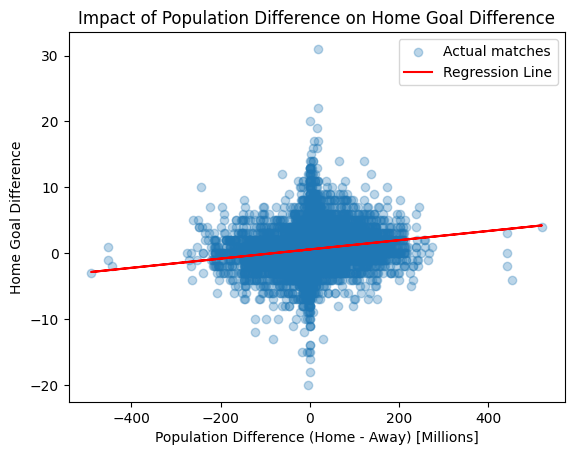


--- No Neutral Matches ---
Linear Regression Model:
Home Goal Difference = 0.007657 * Population Difference + 0.654925
R² Score: 0.0291
P-value for Population Difference: 0.000000

Impact Conclusion:
For every 1 million more people at home vs away, home teams score 0.00765680 more goals on average.


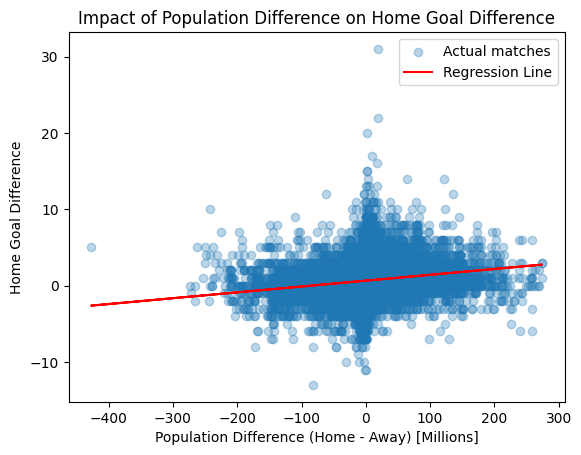


--- No Friendlies and No Neutral Matches ---
Linear Regression Model:
Home Goal Difference = 0.008460 * Population Difference + 0.723539
R² Score: 0.0312
P-value for Population Difference: 0.000000

Impact Conclusion:
For every 1 million more people at home vs away, home teams score 0.00846044 more goals on average.


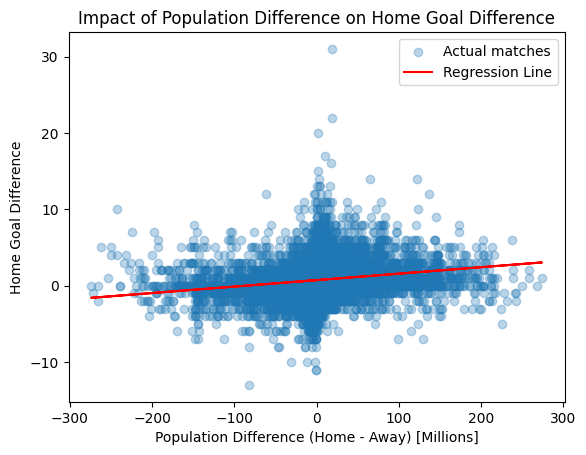

In [15]:
print("------------------Points DIFFERENCE______________________________")

print("--- Original mergedData ---")
modelPop = analyze_population_impact(mergedData)

print("\n--- No Friendlies ---")
modelPop_no_friendlies = analyze_population_impact(mergedData_no_friendlies)

print("\n--- No Neutral Matches ---")
modelPop_no_neutral = analyze_population_impact(mergedData_no_neutral)

print("\n--- No Friendlies and No Neutral Matches ---")
modelPop_no_friendlies_no_neutral = analyze_population_impact(mergedData_no_friendlies_no_neutral)

print("------------------GOAL DIFFERENCE______________________________")

# Predict with different datasets
print("--- Original mergedData ---")
modelGoal_goal_diff = analyze_goal_difference_impact(mergedData)

print("\n--- No Friendlies ---")
modelGoal_no_friendlies_goal_diff = analyze_goal_difference_impact(mergedData_no_friendlies)

print("\n--- No Neutral Matches ---")
modelGoal_no_neutral_goal_diff = analyze_goal_difference_impact(mergedData_no_neutral)

print("\n--- No Friendlies and No Neutral Matches ---")
modelGoal_no_friendlies_no_neutral_goal_diff = analyze_goal_difference_impact(mergedData_no_friendlies_no_neutral)

### Ranking Impact Analysis
# analyze_ranking_impact  
Prepares ranking difference vs. home points, fits a linear regression, prints coefficient, intercept & R², explains impact, and plots the regression line.

# analyze_ranking_goal_difference_impact  
Prepares ranking difference vs. home goal difference, fits a linear regression, prints model stats (coef, intercept & R²), explains impact, and plots the regression line.

In [16]:
def analyze_ranking_impact(results: pd.DataFrame, scale_population: bool = True):
    
    # 1. Prepare data
    X = results[['ranking_difference']]
    y = results['home_points']

    # 2. Train model
    model = LinearRegression()
    model.fit(X, y)

    # 3. Predictions
    predictions = model.predict(X)

    # 4. Print model info
    print("Linear Regression Model:")
    print(f"Home Points = {model.coef_[0]:.6f} * Ranking Difference + {model.intercept_:.6f}")
    print(f"R² Score: {model.score(X, y):.4f}")

    # 5. Impact explanation
    print("\nImpact:")
    print(f"For every 1 place better home ranking vs away, home teams earn {model.coef_[0]:.6} additional points on average.")

    # 6. Plot
    plt.scatter(X, y, alpha=0.3, label="Actual matches")
    plt.plot(X, predictions, color='red', label="Regression Line")
    plt.xlabel('Ranking Difference (Away Rank - Home Rank)')
    plt.ylabel('Home Points')
    plt.title('Impact of Ranking Difference on Home Points')
    plt.legend()
    plt.show()

    return model
def analyze_ranking_goal_difference_impact(results: pd.DataFrame):
    """
    Analyzes the impact of ranking difference on home goal difference.
    """

    # 1. Prepare data
    X = results[['ranking_difference']]
    y = results['home_goal_difference']

    # 2. Train model
    model = LinearRegression()
    model.fit(X, y)

    # 3. Predictions
    predictions = model.predict(X)

    # 4. Print model info
    print("Linear Regression Model:")
    print(f"Home Goal Difference = {model.coef_[0]:.6f} * Ranking Difference + {model.intercept_:.6f}")
    print(f"R² Score: {model.score(X, y):.4f}")

    # 5. Impact explanation
    print("\nImpact:")
    print(f"For every 1 place better home ranking vs away, home teams score {model.coef_[0]:.6f} more goals on average.")

    # 6. Plot
    plt.scatter(X, y, alpha=0.3, label="Actual matches")
    plt.plot(X, predictions, color='red', label="Regression Line")
    plt.xlabel('Ranking Difference (Away Rank - Home Rank)')
    plt.ylabel('Home Goal Difference')
    plt.title('Impact of Ranking Difference on Home Goal Difference')
    plt.legend()
    plt.show()

    return model


------------------Points DIFFERENCE______________________________
--- Original mergedData ---
Linear Regression Model:
Home Points = 0.010121 * Ranking Difference + 1.664657
R² Score: 0.1893

Impact:
For every 1 place better home ranking vs away, home teams earn 0.0101208 additional points on average.


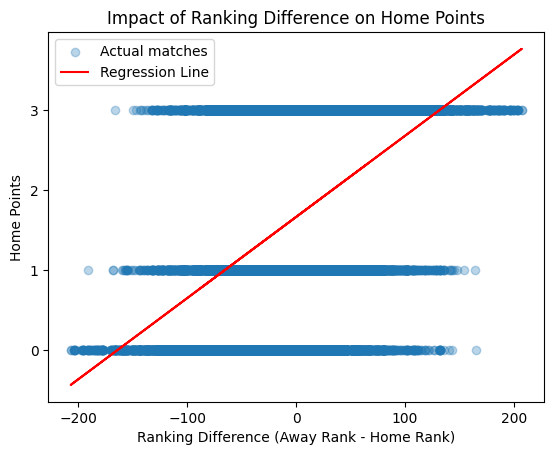


--- No Friendlies ---
Linear Regression Model:
Home Points = 0.010471 * Ranking Difference + 1.676536
R² Score: 0.2258

Impact:
For every 1 place better home ranking vs away, home teams earn 0.0104707 additional points on average.


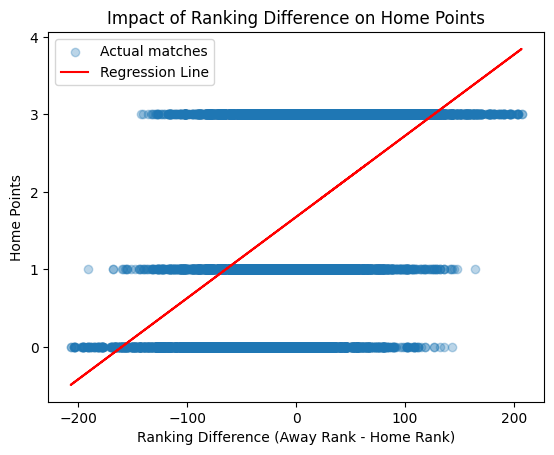


--- No Neutral Matches ---
Linear Regression Model:
Home Points = 0.010031 * Ranking Difference + 1.725840
R² Score: 0.2011

Impact:
For every 1 place better home ranking vs away, home teams earn 0.0100308 additional points on average.


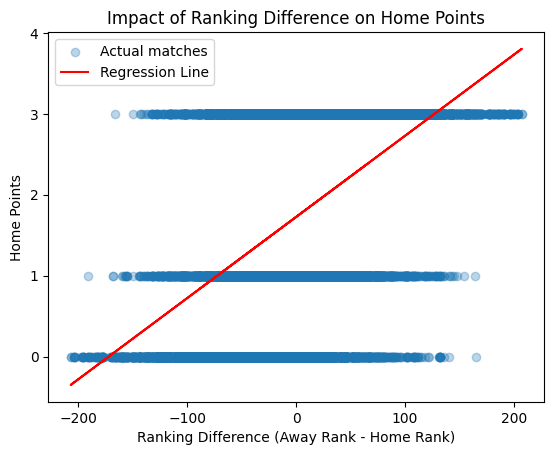


--- No Friendlies and No Neutral Matches ---
Linear Regression Model:
Home Points = 0.010504 * Ranking Difference + 1.752499
R² Score: 0.2578

Impact:
For every 1 place better home ranking vs away, home teams earn 0.0105044 additional points on average.


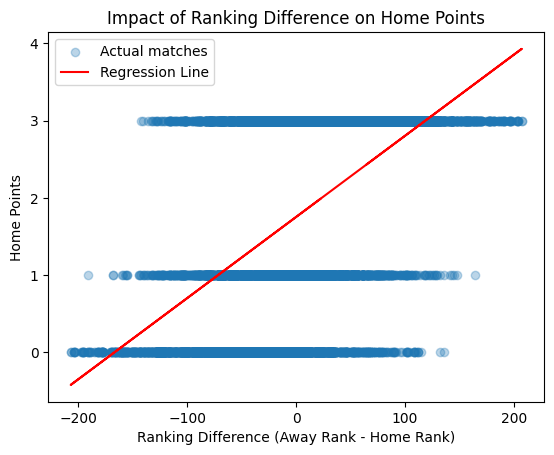

------------------GOAL DIFFERENCE______________________________
--- Original mergedData ---
Linear Regression Model:
Home Goal Difference = 0.019517 * Ranking Difference + 0.493935
R² Score: 0.2451

Impact:
For every 1 place better home ranking vs away, home teams score 0.019517 more goals on average.


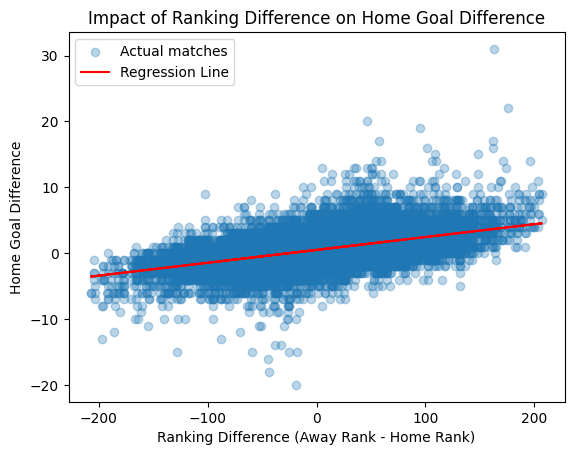


--- No Friendlies ---
Linear Regression Model:
Home Goal Difference = 0.021073 * Ranking Difference + 0.533448
R² Score: 0.2785

Impact:
For every 1 place better home ranking vs away, home teams score 0.021073 more goals on average.


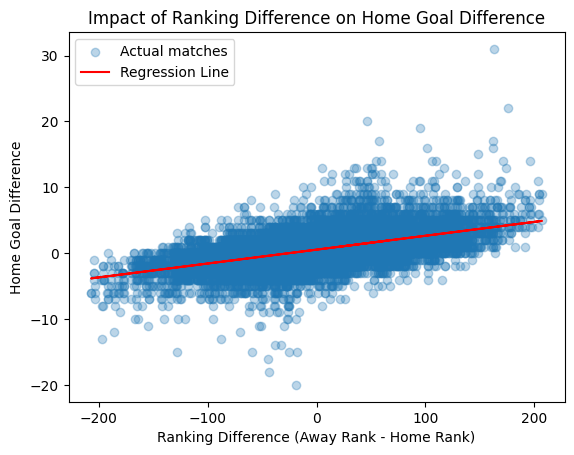


--- No Neutral Matches ---
Linear Regression Model:
Home Goal Difference = 0.019222 * Ranking Difference + 0.601918
R² Score: 0.2699

Impact:
For every 1 place better home ranking vs away, home teams score 0.019222 more goals on average.


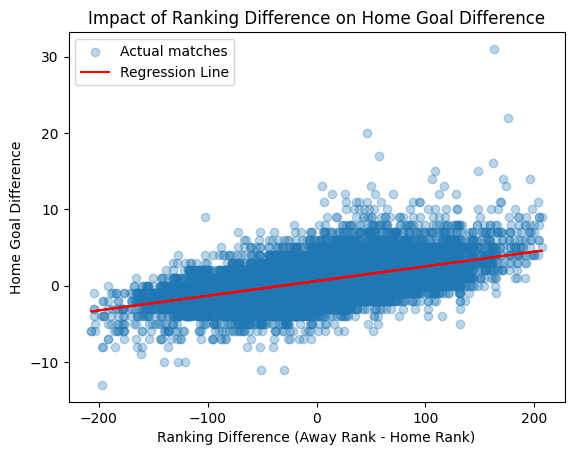


--- No Friendlies and No Neutral Matches ---
Linear Regression Model:
Home Goal Difference = 0.020904 * Ranking Difference + 0.676736
R² Score: 0.3262

Impact:
For every 1 place better home ranking vs away, home teams score 0.020904 more goals on average.


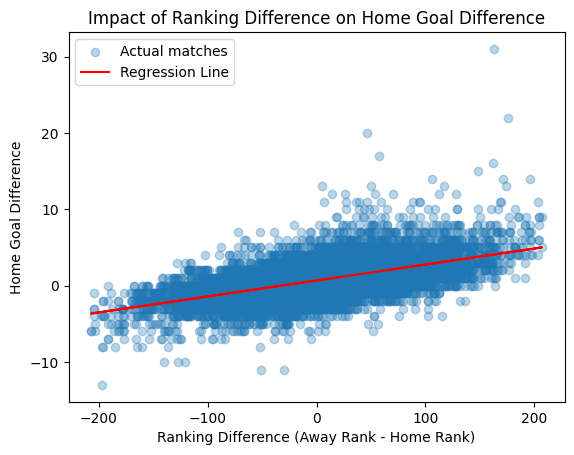

In [17]:
print("------------------Points DIFFERENCE______________________________")
print("--- Original mergedData ---")
modelRank = analyze_ranking_impact(mergedData)

print("\n--- No Friendlies ---")
modelRank_no_friendlies = analyze_ranking_impact(mergedData_no_friendlies)

print("\n--- No Neutral Matches ---")
modelRank_no_neutral = analyze_ranking_impact(mergedData_no_neutral)

print("\n--- No Friendlies and No Neutral Matches ---")
modelRank_no_friendlies_no_neutral = analyze_ranking_impact(mergedData_no_friendlies_no_neutral)

print("------------------GOAL DIFFERENCE______________________________")

print("--- Original mergedData ---")
modelRank_goal_diff = analyze_ranking_goal_difference_impact(mergedData)

print("\n--- No Friendlies ---")
modelRank_no_friendlies_goal_diff = analyze_ranking_goal_difference_impact(mergedData_no_friendlies)

print("\n--- No Neutral Matches ---")
modelRank_no_neutral_goal_diff = analyze_ranking_goal_difference_impact(mergedData_no_neutral)

print("\n--- No Friendlies and No Neutral Matches ---")
modelRank_no_friendlies_no_neutral_goal_diff = analyze_ranking_goal_difference_impact(mergedData_no_friendlies_no_neutral)


### Combined Impact on Home Points
# analyze_combined_impact  
Fits multiple linear regression using population & ranking differences, prints coefficients, R² & p-values, and plots a 3D surface of predicted home points.

### Combined Impact on Home Goal Difference
# analyze_combined_goal_difference_impact  
Fits multiple linear regression using population & ranking differences, prints coefficients, R² & p-values, and plots a 3D surface of predicted home goal difference.

In [18]:
def analyze_combined_impact(results: pd.DataFrame, scale_population: bool = True):    

    # 1. Prepare data
    X = results[['population_difference', 'ranking_difference']]
    y = results['home_points']

    # 2. Train model
    model = LinearRegression()
    model.fit(X, y)

    #3. Statsmodels for p-value
    X_with_const = sm.add_constant(X)
    sm_model = sm.OLS(y, X_with_const).fit()

    #4. Print model info
    print("Multiple Linear Regression Model:")
    print(f"Home Points = ({model.coef_[0]:.6f} * Population Difference) + ({model.coef_[1]:.6f} * Ranking Difference) + {model.intercept_:.6f}")
    print(f"R² Score: {model.score(X, y):.4f}")
    print(f"P-value for Population Difference: {sm_model.pvalues['population_difference']:.6f}")
    print(f"P-value for Ranking Difference: {sm_model.pvalues['ranking_difference']:.6f}")

    # 5. Impact conclusion
    print("\nImpact Conclusion:")
    if scale_population:
        print(f"For every 1 million more people (home vs away), home teams earn {model.coef_[0]:.8f} additional points.")
    else:
        print(f"For every 1 person more (home vs away), home teams earn {model.coef_[0]:.8f} additional points.")
    
    print(f"For every 1 place better home ranking vs away, home teams earn {model.coef_[1]:.6f} additional points.")

    # 6. 3D Plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(results['population_difference'], results['ranking_difference'], y, alpha=0.3, label='Actual matches')

    x_surf, y_surf = np.meshgrid(
        np.linspace(results['population_difference'].min(), results['population_difference'].max(), 100),
        np.linspace(results['ranking_difference'].min(), results['ranking_difference'].max(), 100)
    )
    z_surf = model.intercept_ + model.coef_[0] * x_surf + model.coef_[1] * y_surf

    ax.plot_surface(x_surf, y_surf, z_surf, color='red', alpha=0.5)
    ax.set_xlabel('Population Difference (Millions)' if scale_population else 'Population Difference')
    ax.set_ylabel('Ranking Difference')
    ax.set_zlabel('Home Points')
    ax.set_title('3D Impact of Population and Ranking Differences')
    plt.show()

    return model

def analyze_combined_goal_difference_impact(results: pd.DataFrame, scale_population: bool = True):
    """
    Analyzes the combined impact of population difference and ranking difference on home goal difference.
    """

    # 1. Prepare data
    X = results[['population_difference', 'ranking_difference']]
    y = results['home_goal_difference']

    # 2. Train model
    model = LinearRegression()
    model.fit(X, y)

    # 3. Statsmodels for p-value
    X_with_const = sm.add_constant(X)
    sm_model = sm.OLS(y, X_with_const).fit()

    # 4. Print model info
    print("Multiple Linear Regression Model:")
    print(f"Home Goal Difference = ({model.coef_[0]:.6f} * Population Difference) + ({model.coef_[1]:.6f} * Ranking Difference) + {model.intercept_:.6f}")
    print(f"R² Score: {model.score(X, y):.4f}")
    print(f"P-value for Population Difference: {sm_model.pvalues['population_difference']:.6f}")
    print(f"P-value for Ranking Difference: {sm_model.pvalues['ranking_difference']:.6f}")

    # 5. Impact conclusion
    print("\nImpact Conclusion:")
    if scale_population:
        print(f"For every 1 million more people (home vs away), home teams score {model.coef_[0]:.8f} additional goals.")
    else:
        print(f"For every 1 person more (home vs away), home teams score {model.coef_[0]:.8f} additional goals.")
    
    print(f"For every 1 place better home ranking vs away, home teams score {model.coef_[1]:.6f} additional goals.")

    # 6. 3D Plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(results['population_difference'], results['ranking_difference'], y, alpha=0.3, label='Actual matches')
    
    x_surf, y_surf = np.meshgrid(
        np.linspace(results['population_difference'].min(), results['population_difference'].max(), 100),
        np.linspace(results['ranking_difference'].min(), results['ranking_difference'].max(), 100)
    )
    z_surf = model.intercept_ + model.coef_[0] * x_surf + model.coef_[1] * y_surf
    
    # Corrected here!
    ax.plot_surface(x_surf, y_surf, z_surf, color='red', alpha=0.5)
    
    ax.set_xlabel('Population Difference (Millions)' if scale_population else 'Population Difference')
    ax.set_ylabel('Ranking Difference')
    ax.set_zlabel('Home Goal Difference')
    ax.set_title('3D Impact of Population and Ranking Differences on Home Goal Difference')
    plt.show()


    return model
    

------------------Points DIFFERENCE______________________________
--- Original mergedData ---
Multiple Linear Regression Model:
Home Points = (0.001245 * Population Difference) + (0.009855 * Ranking Difference) + 1.661881
R² Score: 0.1915
P-value for Population Difference: 0.000000
P-value for Ranking Difference: 0.000000

Impact Conclusion:
For every 1 million more people (home vs away), home teams earn 0.00124450 additional points.
For every 1 place better home ranking vs away, home teams earn 0.009855 additional points.


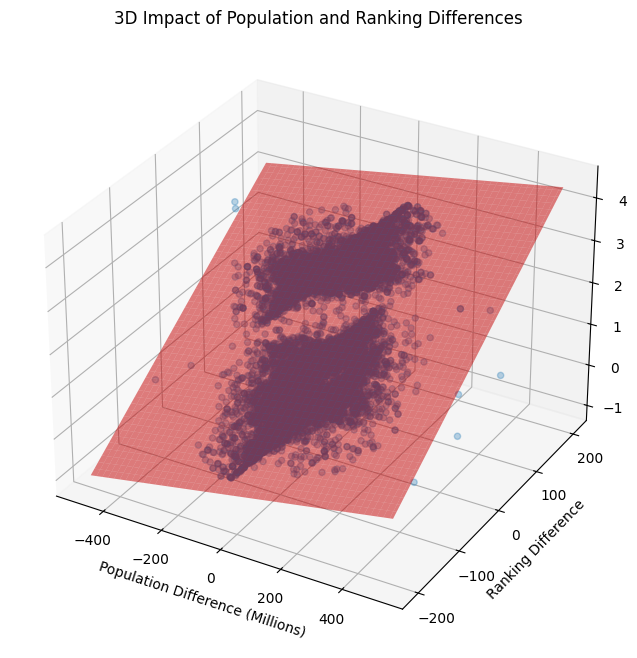


--- No Friendlies ---
Multiple Linear Regression Model:
Home Points = (0.001034 * Population Difference) + (0.010261 * Ranking Difference) + 1.674421
R² Score: 0.2273
P-value for Population Difference: 0.000000
P-value for Ranking Difference: 0.000000

Impact Conclusion:
For every 1 million more people (home vs away), home teams earn 0.00103427 additional points.
For every 1 place better home ranking vs away, home teams earn 0.010261 additional points.


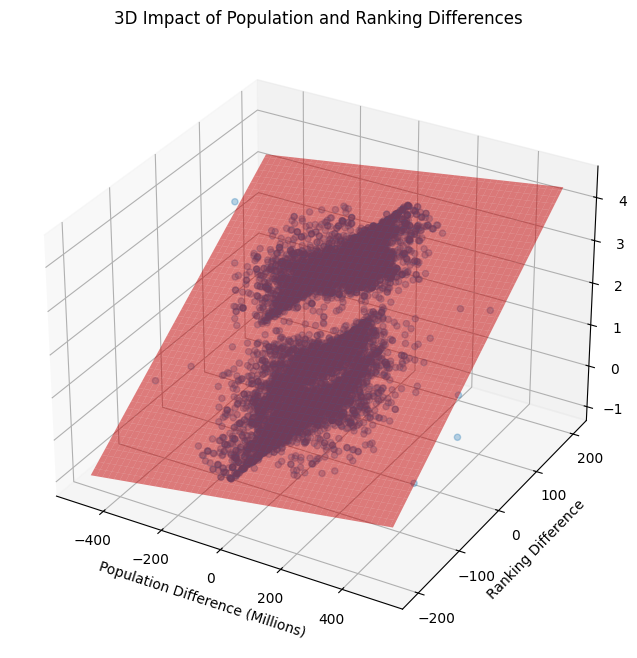


--- No Neutral Matches ---
Multiple Linear Regression Model:
Home Points = (0.001582 * Population Difference) + (0.009699 * Ranking Difference) + 1.723905
R² Score: 0.2042
P-value for Population Difference: 0.000000
P-value for Ranking Difference: 0.000000

Impact Conclusion:
For every 1 million more people (home vs away), home teams earn 0.00158194 additional points.
For every 1 place better home ranking vs away, home teams earn 0.009699 additional points.


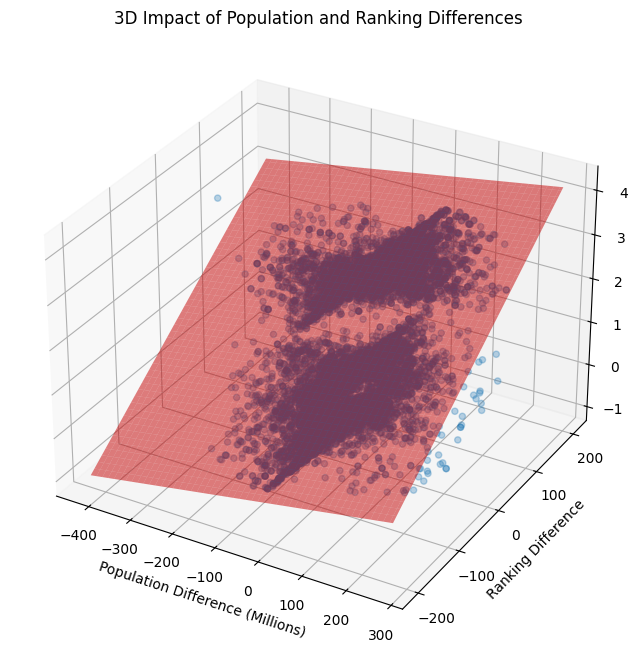


--- No Friendlies and No Neutral Matches ---
Multiple Linear Regression Model:
Home Points = (0.001258 * Population Difference) + (0.010245 * Ranking Difference) + 1.751016
R² Score: 0.2598
P-value for Population Difference: 0.000000
P-value for Ranking Difference: 0.000000

Impact Conclusion:
For every 1 million more people (home vs away), home teams earn 0.00125841 additional points.
For every 1 place better home ranking vs away, home teams earn 0.010245 additional points.


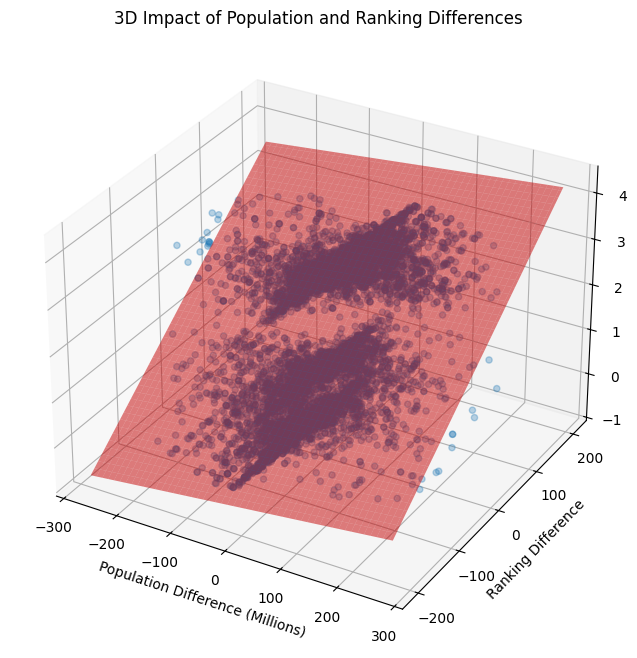

------------------GOAL DIFFERENCE______________________________
--- Original mergedData ---
Multiple Linear Regression Model:
Home Goal Difference = (0.001549 * Population Difference) + (0.019186 * Ranking Difference) + 0.490479
R² Score: 0.2462
P-value for Population Difference: 0.000000
P-value for Ranking Difference: 0.000000

Impact Conclusion:
For every 1 million more people (home vs away), home teams score 0.00154916 additional goals.
For every 1 place better home ranking vs away, home teams score 0.019186 additional goals.


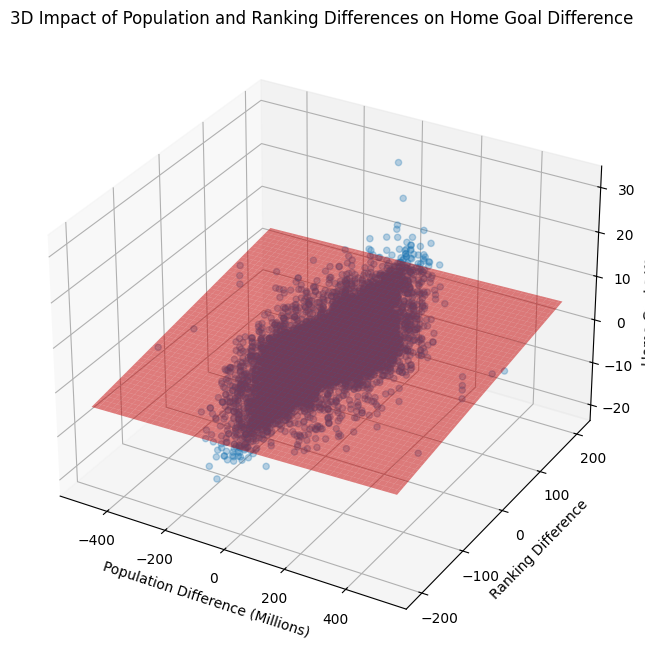


--- No Friendlies ---
Multiple Linear Regression Model:
Home Goal Difference = (0.001198 * Population Difference) + (0.020831 * Ranking Difference) + 0.530998
R² Score: 0.2791
P-value for Population Difference: 0.000066
P-value for Ranking Difference: 0.000000

Impact Conclusion:
For every 1 million more people (home vs away), home teams score 0.00119789 additional goals.
For every 1 place better home ranking vs away, home teams score 0.020831 additional goals.


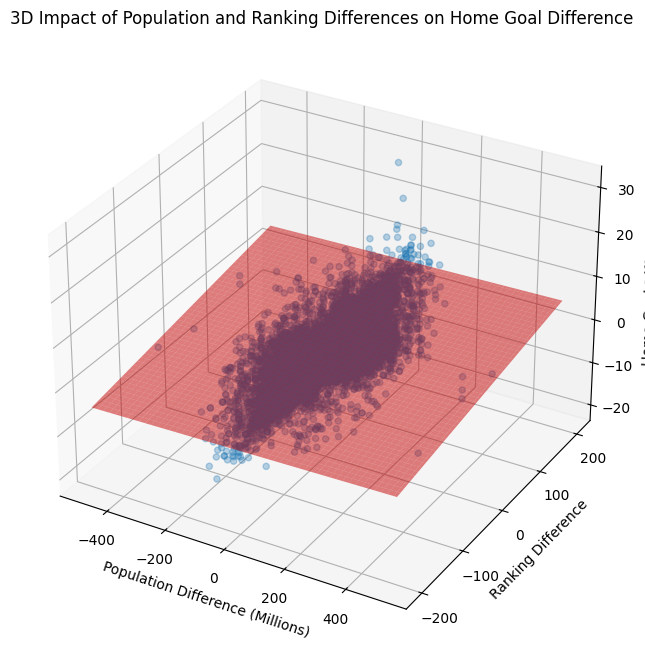


--- No Neutral Matches ---
Multiple Linear Regression Model:
Home Goal Difference = (0.001839 * Population Difference) + (0.018835 * Ranking Difference) + 0.599669
R² Score: 0.2715
P-value for Population Difference: 0.000000
P-value for Ranking Difference: 0.000000

Impact Conclusion:
For every 1 million more people (home vs away), home teams score 0.00183948 additional goals.
For every 1 place better home ranking vs away, home teams score 0.018835 additional goals.


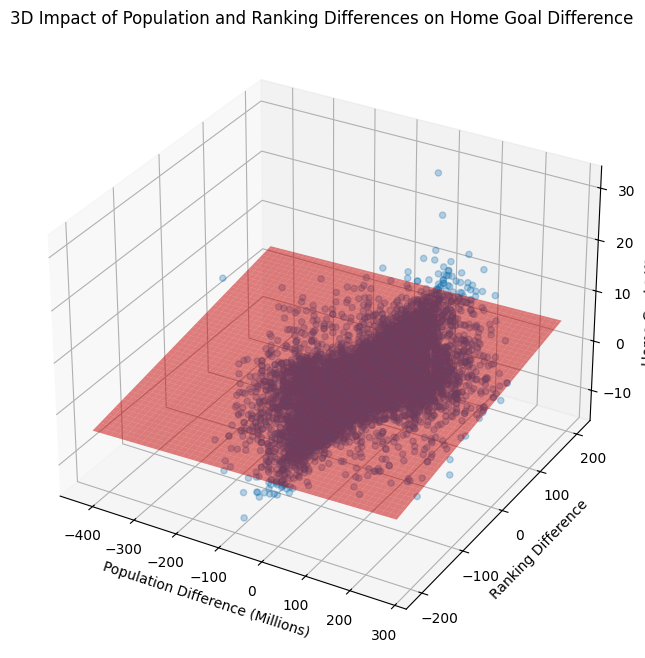


--- No Friendlies and No Neutral Matches ---
Multiple Linear Regression Model:
Home Goal Difference = (0.001146 * Population Difference) + (0.020668 * Ranking Difference) + 0.675385
R² Score: 0.3267
P-value for Population Difference: 0.001564
P-value for Ranking Difference: 0.000000

Impact Conclusion:
For every 1 million more people (home vs away), home teams score 0.00114647 additional goals.
For every 1 place better home ranking vs away, home teams score 0.020668 additional goals.


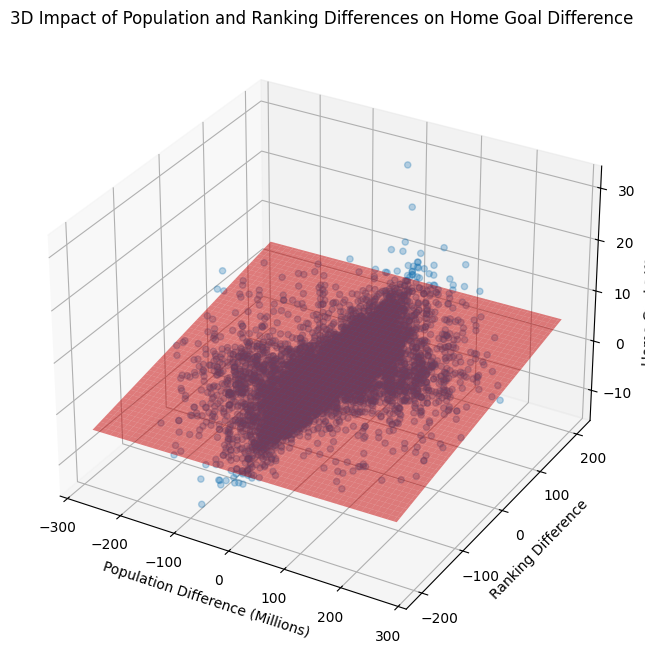

In [19]:
print("------------------Points DIFFERENCE______________________________")


print("--- Original mergedData ---")
modelCombined = analyze_combined_impact(mergedData)

print("\n--- No Friendlies ---")
modelCombined_no_friendlies = analyze_combined_impact(mergedData_no_friendlies)

print("\n--- No Neutral Matches ---")
modelCombined_no_neutral = analyze_combined_impact(mergedData_no_neutral)

print("\n--- No Friendlies and No Neutral Matches ---")
modelCombined_no_friendlies_no_neutral = analyze_combined_impact(mergedData_no_friendlies_no_neutral)

print("------------------GOAL DIFFERENCE______________________________")


print("--- Original mergedData ---")
modelCombined_goal_diff = analyze_combined_goal_difference_impact(mergedData)

print("\n--- No Friendlies ---")
modelCombined_no_friendlies_goal_diff = analyze_combined_goal_difference_impact(mergedData_no_friendlies)

print("\n--- No Neutral Matches ---")
modelCombined_no_neutral_goal_diff = analyze_combined_goal_difference_impact(mergedData_no_neutral)

print("\n--- No Friendlies and No Neutral Matches ---")
modelCombined_no_friendlies_no_neutral_goal_diff = analyze_combined_goal_difference_impact(mergedData_no_friendlies_no_neutral)


### Classification Preparation
# create_outcome_column  
Adds an ‘outcome’ column based on home_points (3 → home_win, 1 → draw, 0 → home_loss).

# prepare_classification_target  
Creates a binary ‘home_win’ target (1 if home_win, else 0).

### Logistic Regression
# run_logistic_regression  
Fits logistic regression on population & ranking differences to predict home wins; prints accuracy, confusion matrix, report, and plots predicted probabilities.

### Random Forest Regression (Home Points)
# run_random_forest_regression  
Fits random forest to predict home points; prints MSE, R², feature importances, and plots actual vs. predicted points plus one decision tree.

### Random Forest Regression (Home Goal Difference)
# run_random_forest_goal_difference_regression  
Fits random forest to predict home goal difference; prints MSE, R², feature importances, and plots actual vs. predicted goal difference plus one decision tree.

In [20]:
# 3 points = home win, 1 point = draw, 0 points = home loss
def create_outcome_column(data):
    data = data.copy()
    def determine_outcome(row):
        if row['home_points'] == 3:
            return 'home_win'
        elif row['home_points'] == 1:
            return 'draw'
        else:
            return 'home_loss'
    data['outcome'] = data.apply(determine_outcome, axis=1)
    return data


def prepare_classification_target(results: pd.DataFrame) -> pd.DataFrame:
    
    results = results.copy()
    results['home_win'] = results['outcome'].apply(lambda x: 1 if x == 'home_win' else 0)
    return results

    
def run_logistic_regression(results: pd.DataFrame):
    

    results = results.copy()
    results['population_difference'] = results['population_difference'] * 1000000


    # Prepare dataset
    results = prepare_classification_target(results)
    X = results[['population_difference', 'ranking_difference']]
    y = results['home_win']

    # Train model
    model = LogisticRegression(max_iter=1000)
    model.fit(X, y)

    # Predict and evaluate
    predictions = model.predict(X)

    acc = accuracy_score(y, predictions)
    cm = confusion_matrix(y, predictions)
    report = classification_report(y, predictions)

    print("=== Logistic Regression Results ===")
    print(f"Accuracy: {acc:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(report)

    # Predicted probabilities
    probs = model.predict_proba(X)[:, 1]  # probability of home win

    plt.figure(figsize=(8,6))
    plt.hist(probs, bins=30, edgecolor='black')
    plt.xlabel('Predicted Probability of Home Win')
    plt.ylabel('Number of Matches')
    plt.title('Logistic Regression: Predicted Probabilities')
    plt.grid()
    plt.show()

    return model
    

def run_random_forest_regression(results: pd.DataFrame):
    """
    Runs Random Forest Regression to predict home points based on population and ranking differences.
    Includes scatter plot of true vs predicted points and a visualization of a decision tree.
    """
   

    results = results.copy()
    results['population_difference'] = results['population_difference'] * 1000000

    
    # Prepare dataset
    X = results[['population_difference', 'ranking_difference']]
    y = results['home_points']

    # Train model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)

    # Predict and evaluate
    predictions = model.predict(X)

    mse = mean_squared_error(y, predictions)
    r2 = r2_score(y, predictions)

    print("=== Random Forest Regression Results ===")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"R² Score: {r2:.4f}")

    # Feature importances
    feature_importances = model.feature_importances_
    for feat, importance in zip(X.columns, feature_importances):
        print(f"{feat}: {importance:.4f}")

    # --- Scatter plot: Actual vs Predicted ---
    plt.figure(figsize=(8,6))
    plt.scatter(y, predictions, alpha=0.5)
    plt.plot([0, 3], [0, 3], 'r--')  # ideal line
    plt.xlabel('Actual Home Points')
    plt.ylabel('Predicted Home Points')
    plt.title('Random Forest: Actual vs Predicted Home Points')
    plt.grid()
    plt.show()

    # --- Visualize one Decision Tree inside the Forest ---
    estimator = model.estimators_[0]  # Pick the first tree for visualization

    plt.figure(figsize=(20, 10))
    plot_tree(
        estimator,
        feature_names=X.columns,
        filled=True,
        rounded=True,
        max_depth=3,  # Only show first 3 levels to keep it readable
        fontsize=10
    )
    plt.title('Visualization of one Decision Tree inside Random Forest')
    plt.show()

    return model


def run_random_forest_goal_difference_regression(results: pd.DataFrame):
    """
    Runs Random Forest Regression to predict home goal difference
    based on population and ranking differences.
    Includes scatter plot of true vs predicted goal difference
    and a visualization of a decision tree.
    """
    results = results.copy()
    results['population_difference'] = results['population_difference'] * 1000000


    # Prepare dataset
    X = results[['population_difference', 'ranking_difference']]
    y = results['home_goal_difference']

    # Train model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)

    # Predict and evaluate
    predictions = model.predict(X)

    mse = mean_squared_error(y, predictions)
    r2 = r2_score(y, predictions)

    print("=== Random Forest Regression Results ===")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"R² Score: {r2:.4f}")

    # Feature importances
    feature_importances = model.feature_importances_
    for feat, importance in zip(X.columns, feature_importances):
        print(f"{feat}: {importance:.4f}")

    # --- Scatter plot: Actual vs Predicted ---
    plt.figure(figsize=(8,6))
    plt.scatter(y, predictions, alpha=0.5)
    plt.plot(
        [y.min(), y.max()], 
        [y.min(), y.max()], 
        'r--'
    )  # ideal line (dynamic based on y range)
    plt.xlabel('Actual Home Goal Difference')
    plt.ylabel('Predicted Home Goal Difference')
    plt.title('Random Forest: Actual vs Predicted Home Goal Difference')
    plt.grid()
    plt.show()

    # --- Visualize one Decision Tree inside the Forest ---
    estimator = model.estimators_[0]  # Pick the first tree for visualization

    plt.figure(figsize=(20, 10))
    plot_tree(
        estimator,
        feature_names=X.columns,
        filled=True,
        rounded=True,
        max_depth=3,  # Only show first 3 levels to keep it readable
        fontsize=10
    )
    plt.title('Visualization of one Decision Tree inside Random Forest')
    plt.show()

    return model



### Model Comparison Across Datasets

# Step 1: Prepare Datasets  
Ensure difference columns exist for each dataset variant.

# Step 2: Train & Evaluate Models  
Run logistic regression and random forest (points & goal diff) on each dataset, storing metrics.


--- Logistic Regression: Original mergedData ---
=== Logistic Regression Results ===
Accuracy: 0.6713
Confusion Matrix:
[[9489 5450]
 [4091 9997]]

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.64      0.67     14939
           1       0.65      0.71      0.68     14088

    accuracy                           0.67     29027
   macro avg       0.67      0.67      0.67     29027
weighted avg       0.67      0.67      0.67     29027



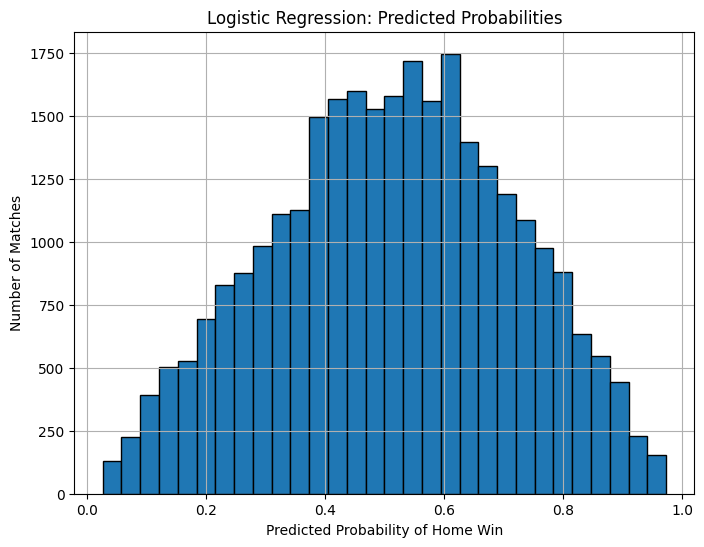


--- Random Forest Regression (Home Points): Original mergedData ---
=== Random Forest Regression Results ===
Mean Squared Error: 0.5581
R² Score: 0.6775
population_difference: 0.5742
ranking_difference: 0.4258


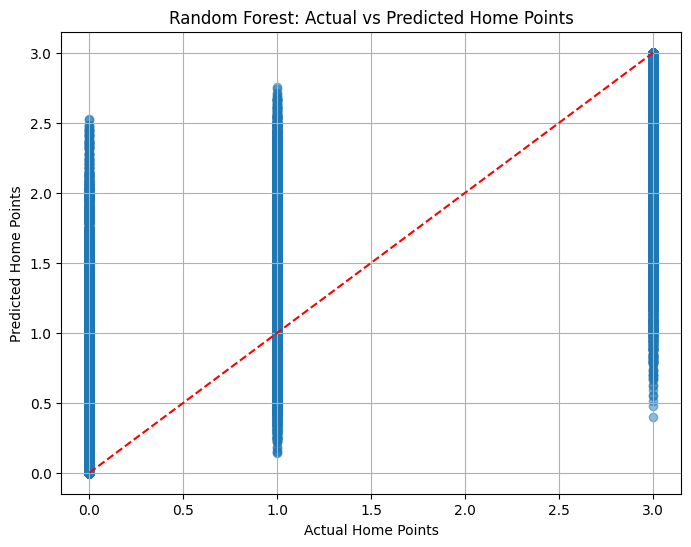

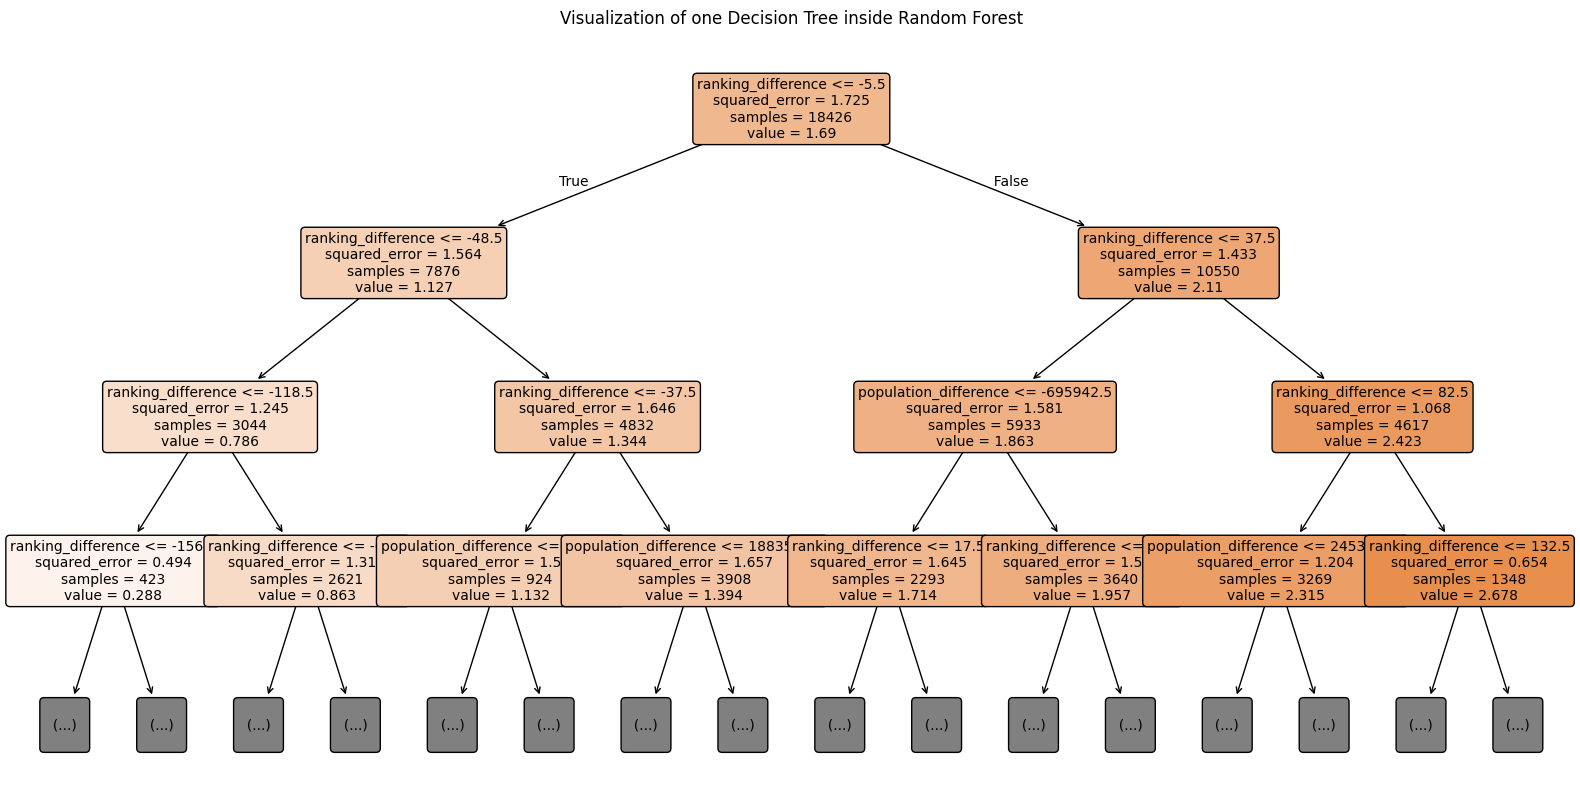


--- Random Forest Regression (Home Goal Difference): Original mergedData ---
=== Random Forest Regression Results ===
Mean Squared Error: 1.1939
R² Score: 0.7598
population_difference: 0.5387
ranking_difference: 0.4613


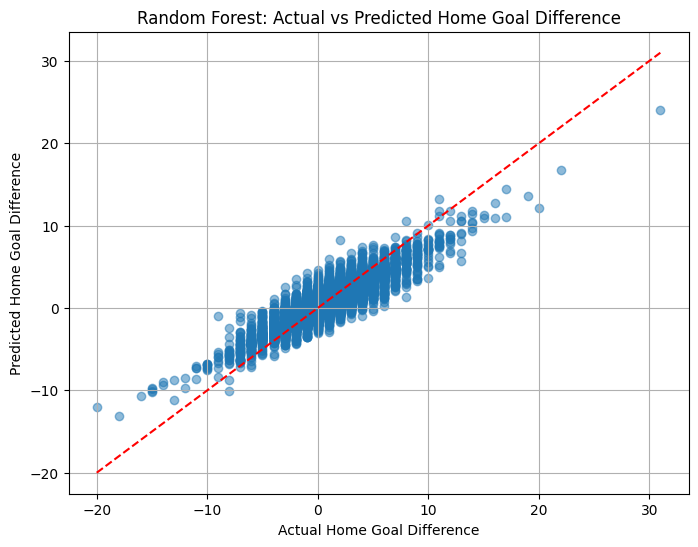

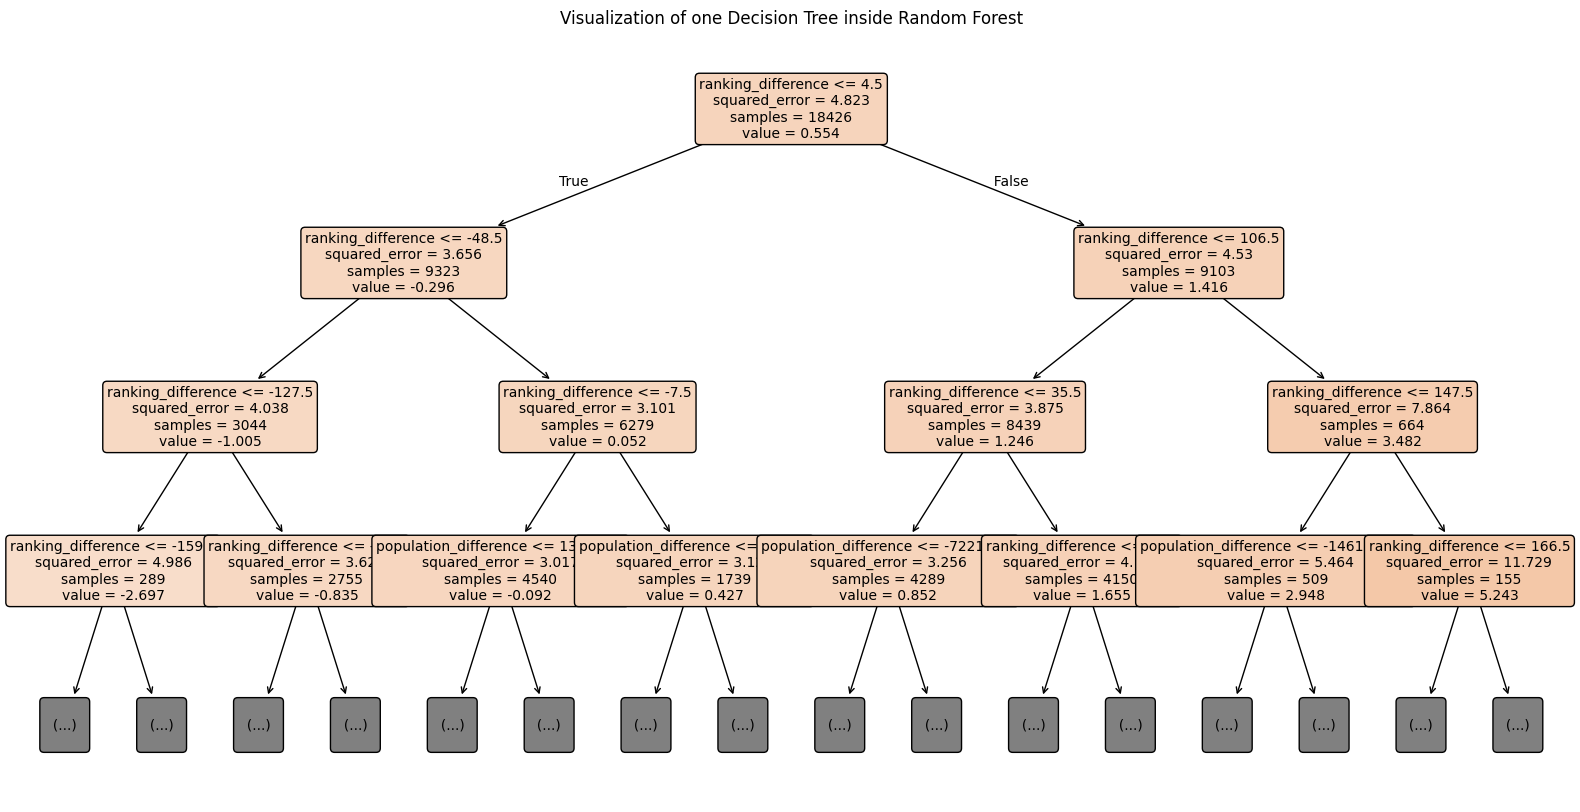


--- Logistic Regression: No Friendlies ---
=== Logistic Regression Results ===
Accuracy: 0.6891
Confusion Matrix:
[[6231 3190]
 [2593 6584]]

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.66      0.68      9421
           1       0.67      0.72      0.69      9177

    accuracy                           0.69     18598
   macro avg       0.69      0.69      0.69     18598
weighted avg       0.69      0.69      0.69     18598



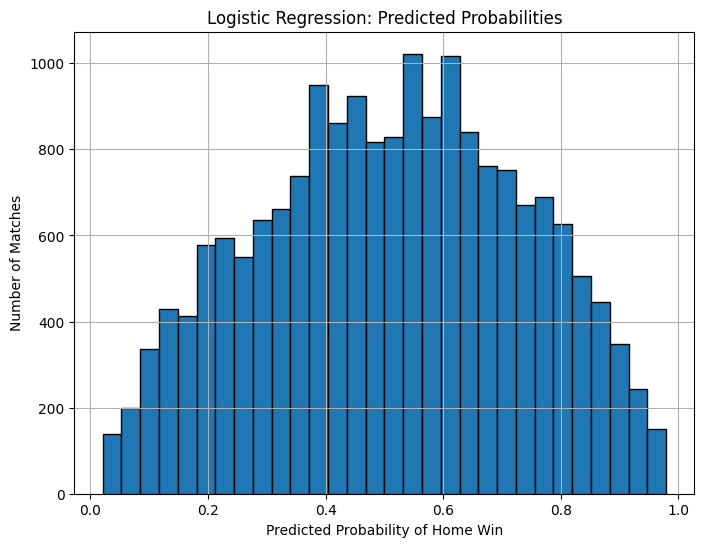


--- Random Forest Regression (Home Points): No Friendlies ---
=== Random Forest Regression Results ===
Mean Squared Error: 0.4745
R² Score: 0.7306
population_difference: 0.5410
ranking_difference: 0.4590


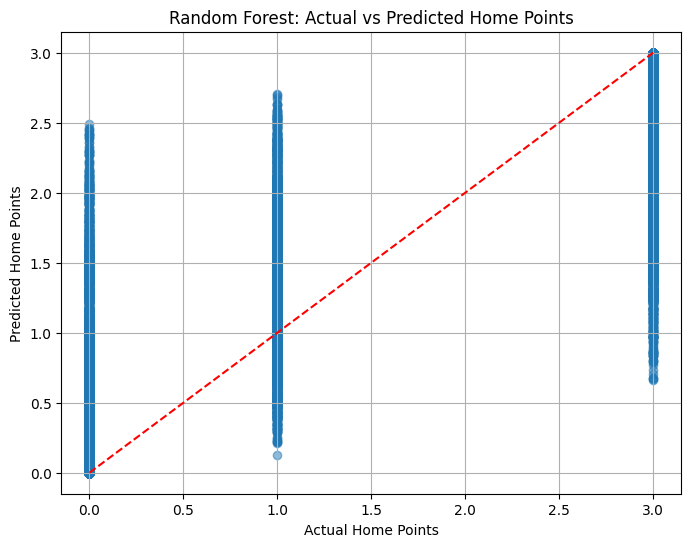

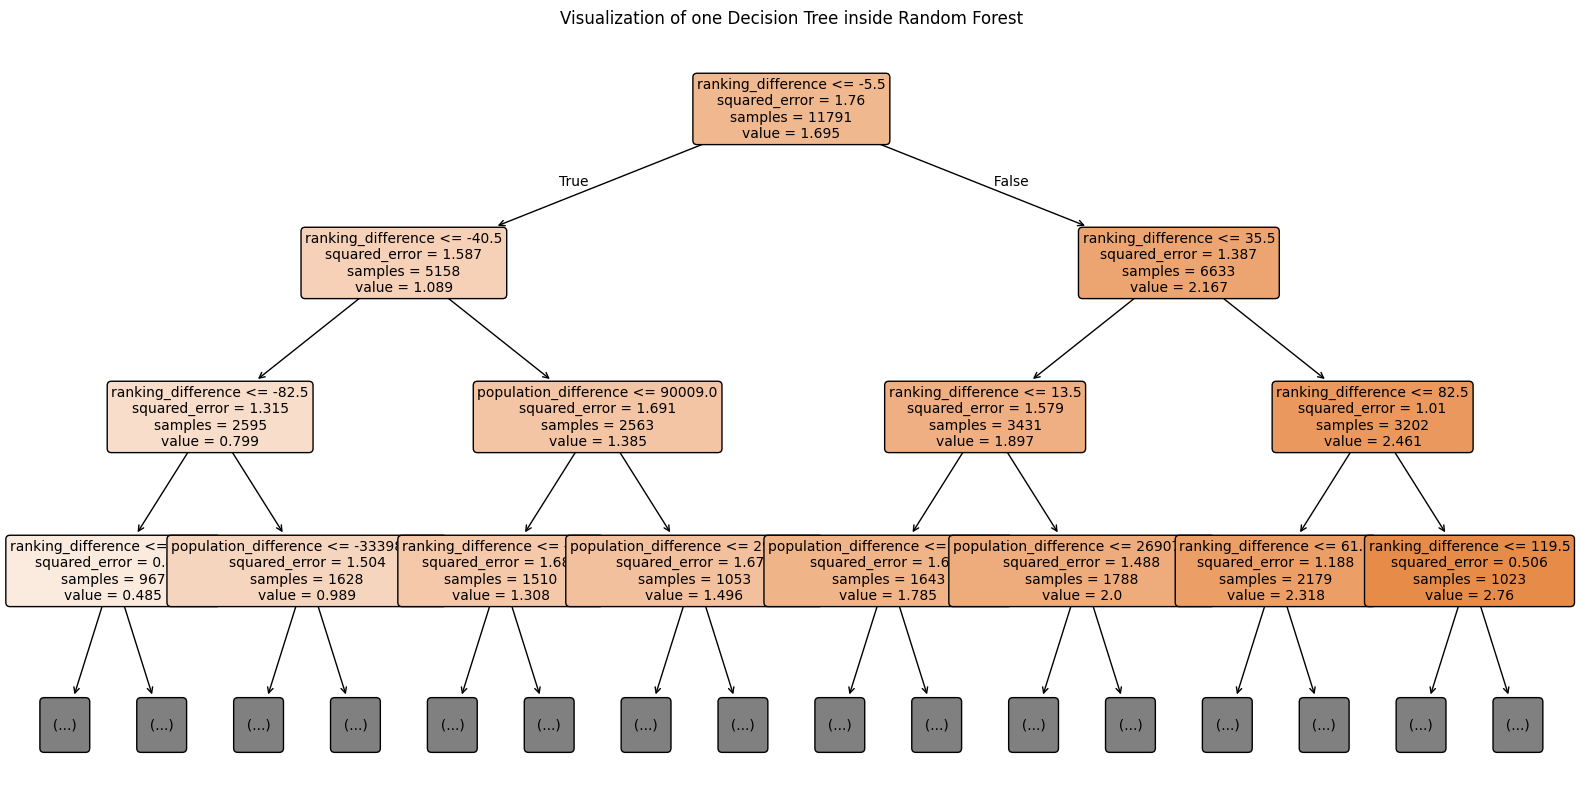


--- Random Forest Regression (Home Goal Difference): No Friendlies ---
=== Random Forest Regression Results ===
Mean Squared Error: 1.1543
R² Score: 0.8005
population_difference: 0.5050
ranking_difference: 0.4950


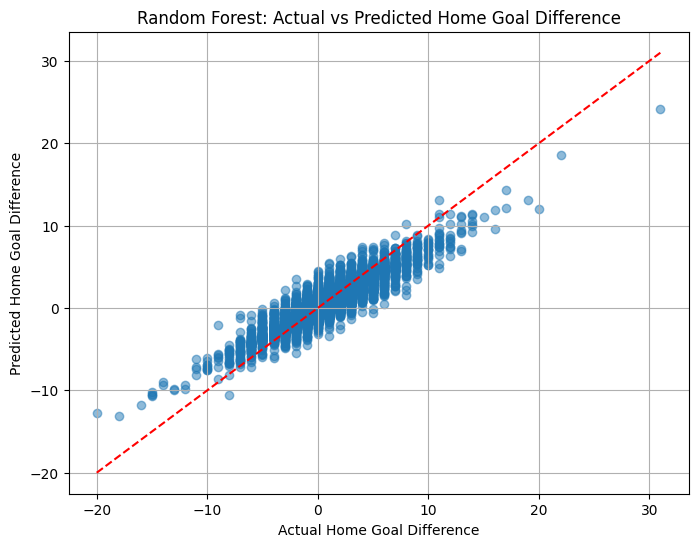

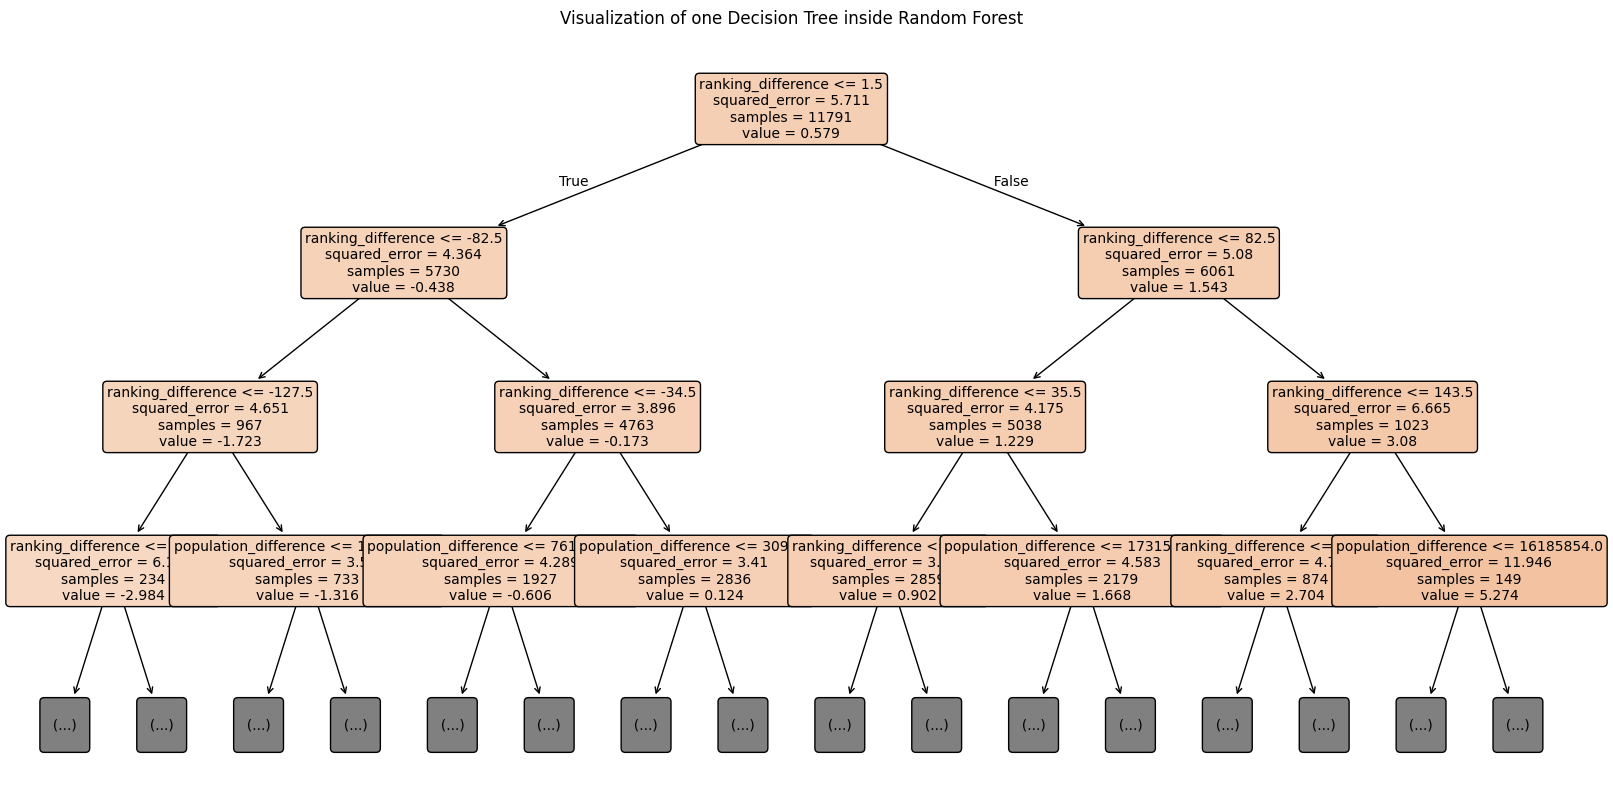


--- Logistic Regression: No Neutral Matches ---
=== Logistic Regression Results ===
Accuracy: 0.6804
Confusion Matrix:
[[6846 3665]
 [3152 7666]]

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.65      0.67     10511
           1       0.68      0.71      0.69     10818

    accuracy                           0.68     21329
   macro avg       0.68      0.68      0.68     21329
weighted avg       0.68      0.68      0.68     21329



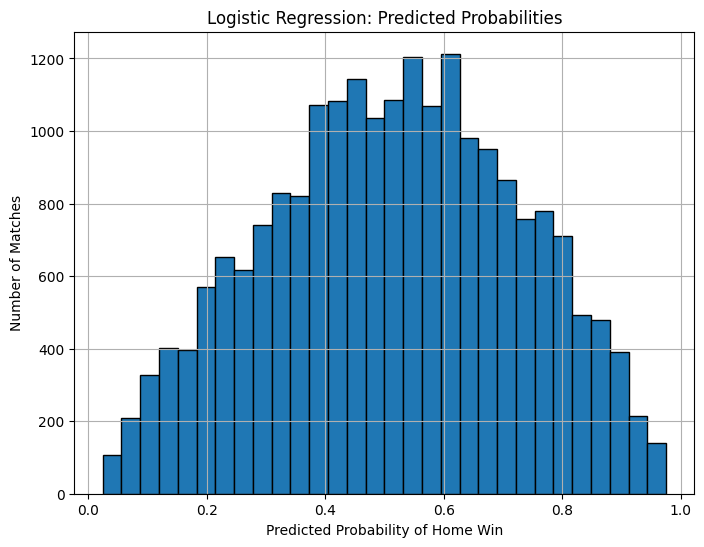


--- Random Forest Regression (Home Points): No Neutral Matches ---
=== Random Forest Regression Results ===
Mean Squared Error: 0.4889
R² Score: 0.7128
population_difference: 0.5645
ranking_difference: 0.4355


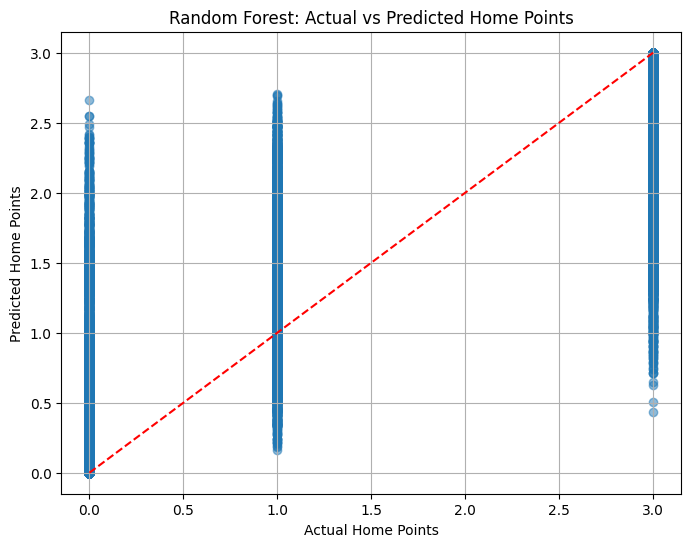

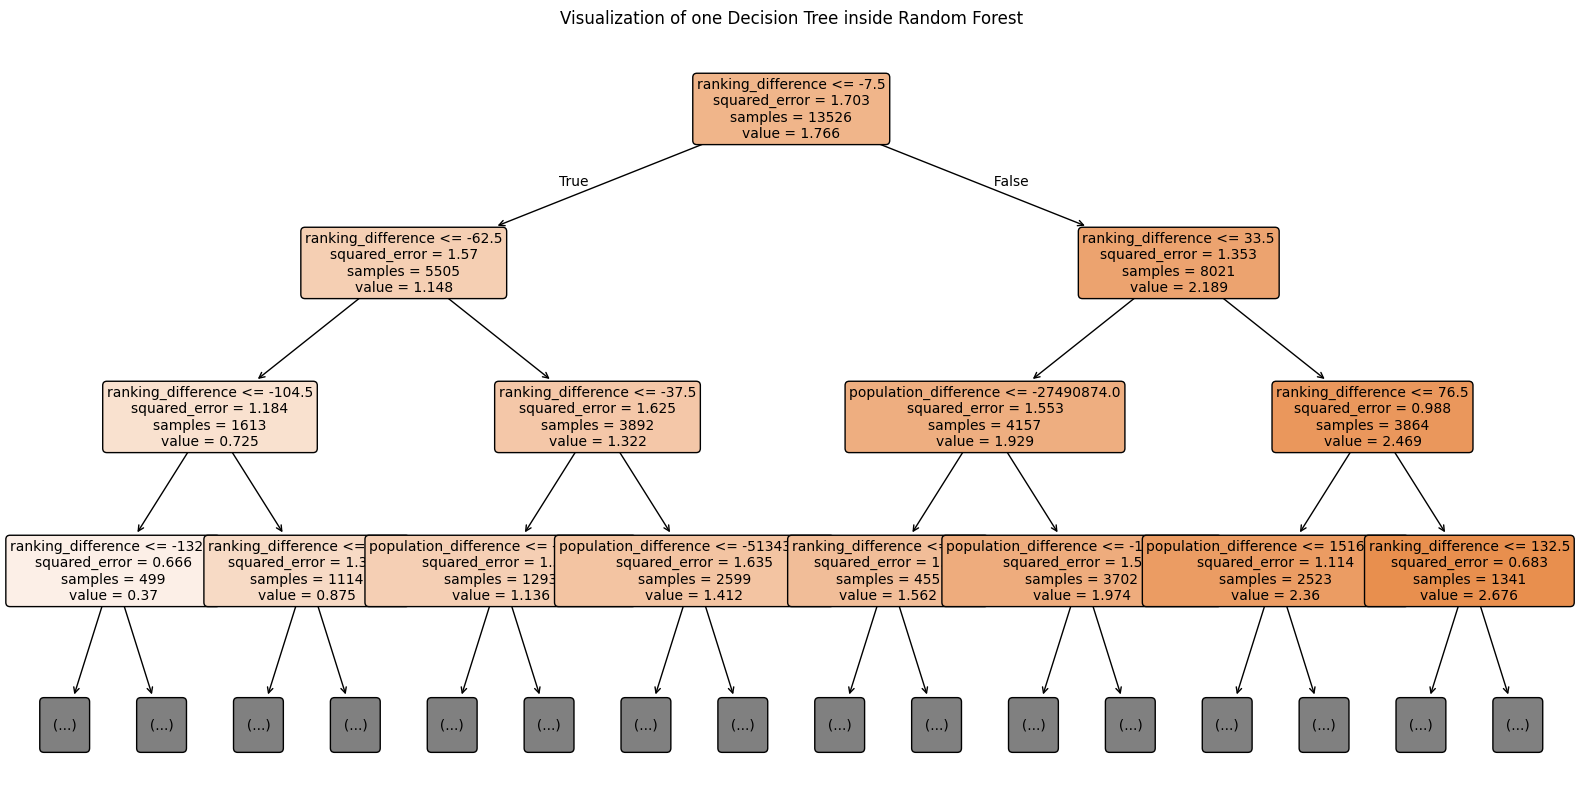


--- Random Forest Regression (Home Goal Difference): No Neutral Matches ---
=== Random Forest Regression Results ===
Mean Squared Error: 1.0220
R² Score: 0.7805
population_difference: 0.5177
ranking_difference: 0.4823


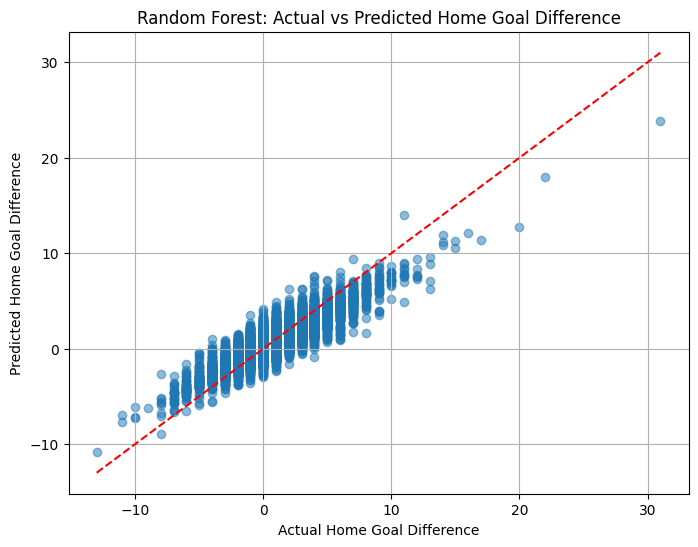

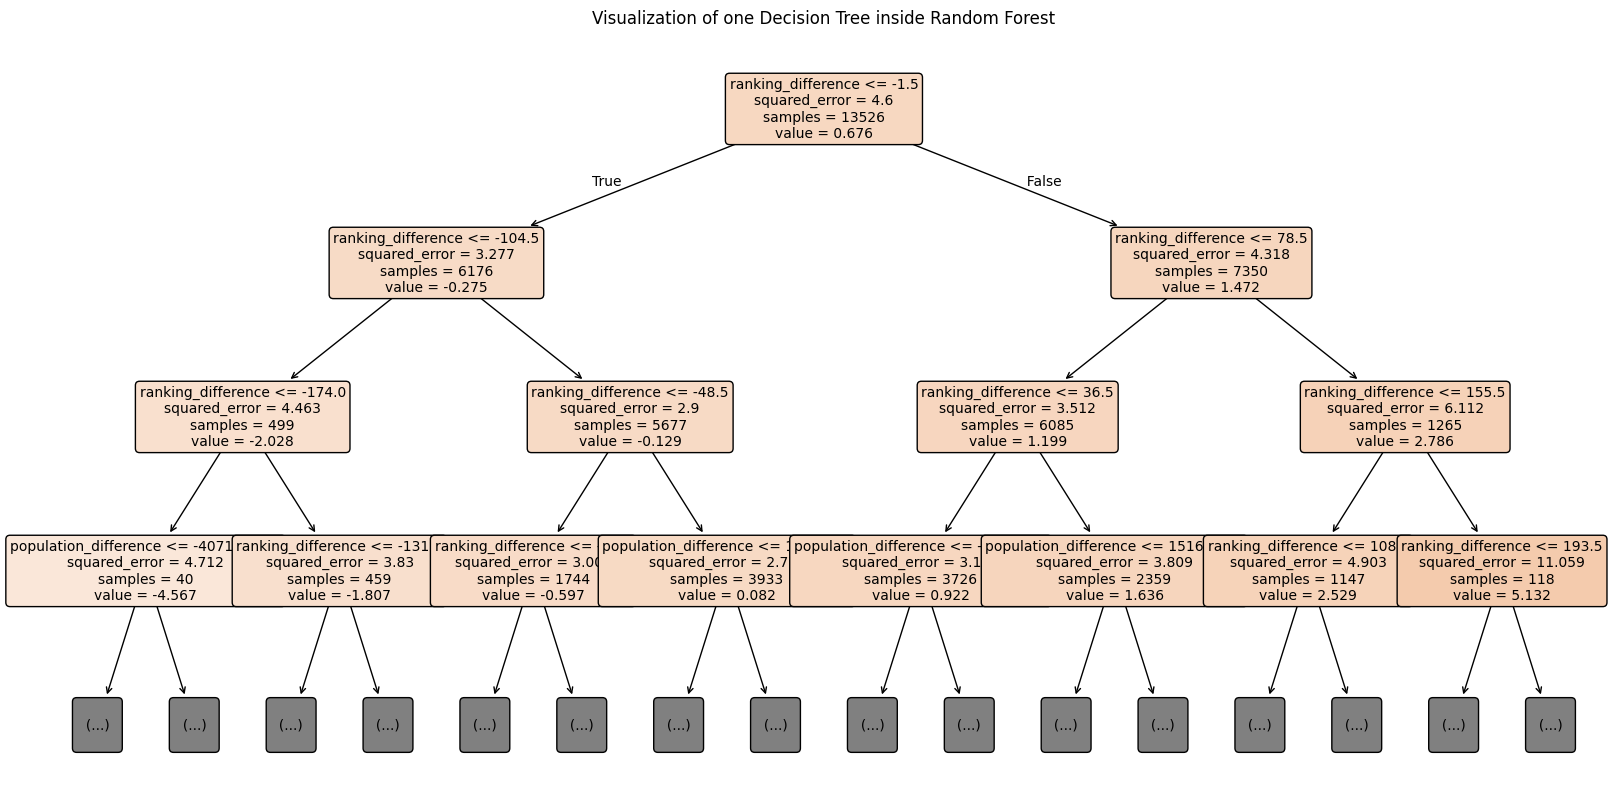


--- Logistic Regression: No Friendlies and No Neutral Matches ---
=== Logistic Regression Results ===
Accuracy: 0.7080
Confusion Matrix:
[[4209 1874]
 [1836 4786]]

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.69      0.69      6083
           1       0.72      0.72      0.72      6622

    accuracy                           0.71     12705
   macro avg       0.71      0.71      0.71     12705
weighted avg       0.71      0.71      0.71     12705



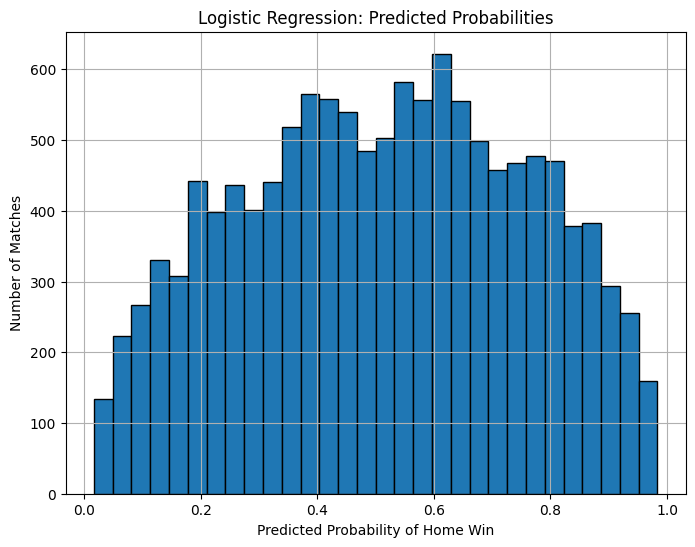


--- Random Forest Regression (Home Points): No Friendlies and No Neutral Matches ---
=== Random Forest Regression Results ===
Mean Squared Error: 0.3775
R² Score: 0.7818
population_difference: 0.5189
ranking_difference: 0.4811


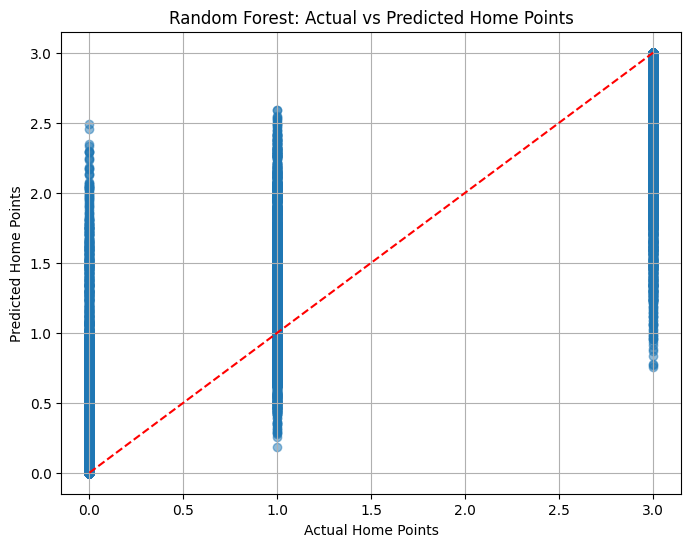

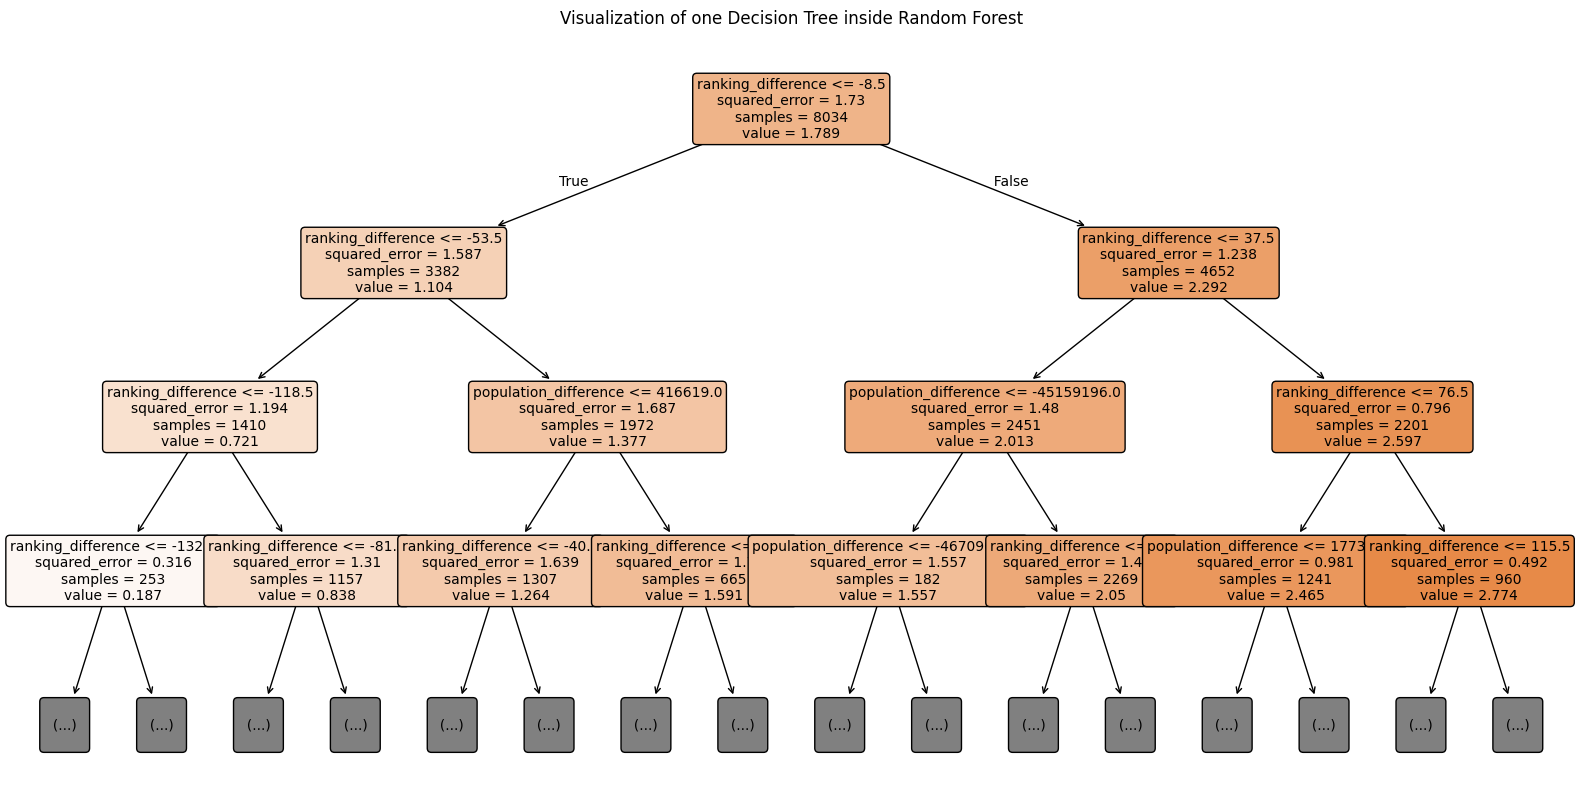


--- Random Forest Regression (Home Goal Difference): No Friendlies and No Neutral Matches ---
=== Random Forest Regression Results ===
Mean Squared Error: 0.9140
R² Score: 0.8311
population_difference: 0.4700
ranking_difference: 0.5300


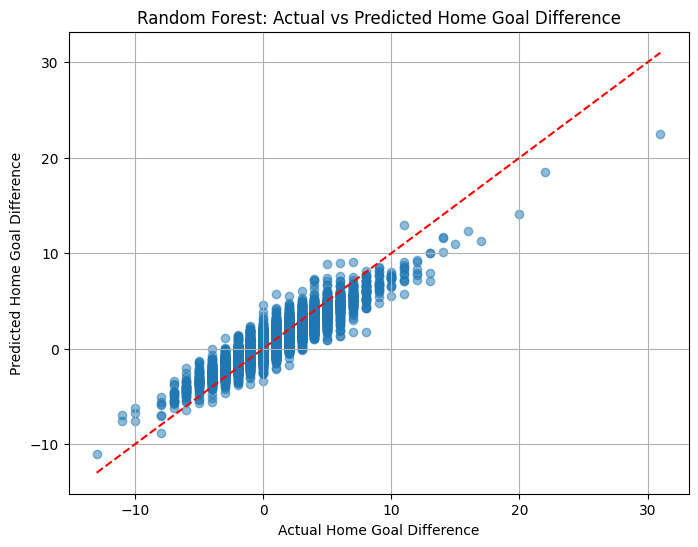

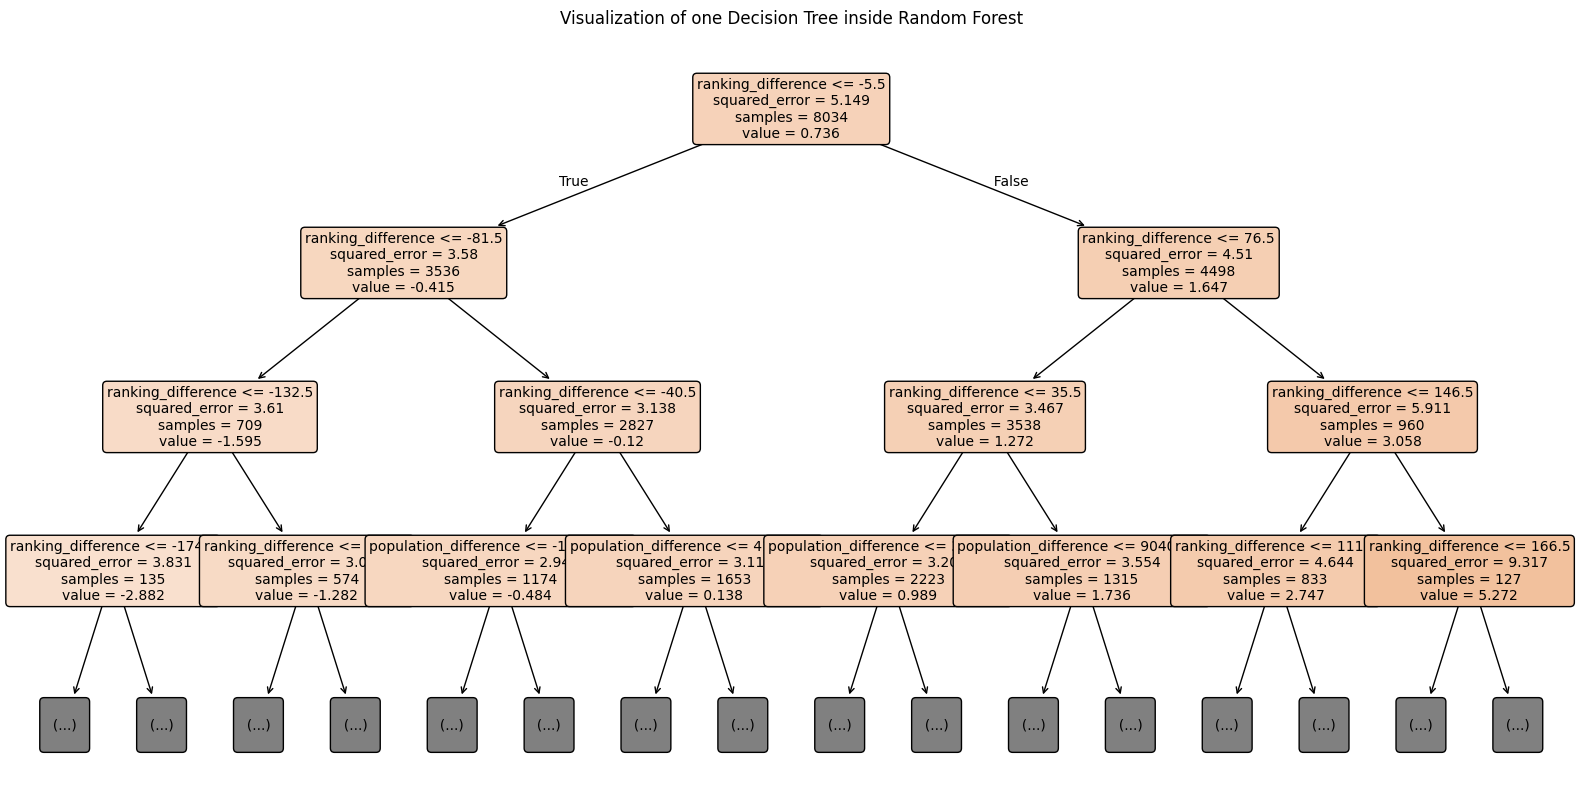

In [21]:
# --- Step 1: Make sure difference columns are created for all datasets ---

datasets = {
    'Original mergedData': mergedData,
    'No Friendlies': mergedData_no_friendlies,
    'No Neutral Matches': mergedData_no_neutral,
    'No Friendlies and No Neutral Matches': mergedData_no_friendlies_no_neutral
}

# --- Step 2: Run models for all datasets and store results ---

logistic_models = {}
random_forest_models = {}
random_forest_goal_diff_models = {}

logistic_accuracies = {}
random_forest_r2_scores = {}
random_forest_goal_diff_r2_scores = {}

for name, data in datasets.items():
    print(f"\n--- Logistic Regression: {name} ---")
    
    # Fix: Create outcome column
    data = create_outcome_column(data)
    
    logistic_model = run_logistic_regression(data)
    logistic_models[name] = logistic_model

    print(f"\n--- Random Forest Regression (Home Points): {name} ---")
    random_forest_model = run_random_forest_regression(data)
    random_forest_models[name] = random_forest_model

    print(f"\n--- Random Forest Regression (Home Goal Difference): {name} ---")
    random_forest_goal_diff_model = run_random_forest_goal_difference_regression(data)
    random_forest_goal_diff_models[name] = random_forest_goal_diff_model

    # --- Prepare X and y for scoring ---

    # Logistic
    X_log = data[['population_difference', 'ranking_difference']].dropna()
    y_log = prepare_classification_target(data.dropna(subset=['population_difference', 'ranking_difference']))['home_win']
    logistic_accuracies[name] = accuracy_score(y_log, logistic_model.predict(X_log))

    # Random Forest (Home Points)
    X_rf = data[['population_difference', 'ranking_difference']].dropna()
    y_rf = data.dropna(subset=['population_difference', 'ranking_difference'])['home_points']
    random_forest_r2_scores[name] = r2_score(y_rf, random_forest_model.predict(X_rf))

    # Random Forest (Home Goal Difference)
    y_rf_goal_diff = data.dropna(subset=['population_difference', 'ranking_difference'])['home_goal_difference']
    random_forest_goal_diff_r2_scores[name] = r2_score(y_rf_goal_diff, random_forest_goal_diff_model.predict(X_rf))




In [22]:
# --- Step 1: Define New Data Point for Prediction ---

new_data = pd.DataFrame({
    'population_difference': [0],
    'ranking_difference': [0]
})

# --- Step 2: Create Model Sets Dictionary (Using Pre-Trained Models) ---

model_sets = {
    'Original mergedData': (
        logistic_models['Original mergedData'],
        random_forest_models['Original mergedData'],
        modelCombined,
        random_forest_goal_diff_models['Original mergedData'],
        modelCombined_goal_diff
    ),
    'No Friendlies': (
        logistic_models['No Friendlies'],
        random_forest_models['No Friendlies'],
        modelCombined_no_friendlies,
        random_forest_goal_diff_models['No Friendlies'],
        modelCombined_no_friendlies_goal_diff
    ),
    'No Neutral Matches': (
        logistic_models['No Neutral Matches'],
        random_forest_models['No Neutral Matches'],
        modelCombined_no_neutral,
        random_forest_goal_diff_models['No Neutral Matches'],
        modelCombined_no_neutral_goal_diff
    ),
    'No Friendlies and No Neutral Matches': (
        logistic_models['No Friendlies and No Neutral Matches'],
        random_forest_models['No Friendlies and No Neutral Matches'],
        modelCombined_no_friendlies_no_neutral,
        random_forest_goal_diff_models['No Friendlies and No Neutral Matches'],
        modelCombined_no_friendlies_no_neutral_goal_diff
    )
}

# --- Step 3: Make Predictions for Each Model Set ---

for name, (logistic_model, rf_model, combined_model, rf_goal_diff_model, combined_goal_diff_model) in model_sets.items():
    print(f"\n=== Predictions using model: {name} ===")
    
    # Logistic Regression prediction (Home Win)
    predicted_home_win = logistic_model.predict(new_data)
    print(f"Predicted outcome (1 = Home win, 0 = Not Home win): {predicted_home_win[0]}")
    
    # Random Forest Regression prediction (Home Points)
    predicted_home_points_rf = rf_model.predict(new_data)
    print(f"Predicted home points (Random Forest): {predicted_home_points_rf[0]:.4f}")
    
    # Combined Linear Regression prediction (Home Points)
    predicted_home_points_combined = combined_model.predict(new_data)
    print(f"Predicted home points (Combined Linear Regression): {predicted_home_points_combined[0]:.4f}")
    
    # Random Forest Regression prediction (Home Goal Difference)
    predicted_goal_difference_rf = rf_goal_diff_model.predict(new_data)
    print(f"Predicted home goal difference (Random Forest): {predicted_goal_difference_rf[0]:.4f}")
    
    # Combined Linear Regression prediction (Home Goal Difference)
    predicted_goal_difference_combined = combined_goal_diff_model.predict(new_data)
    print(f"Predicted home goal difference (Combined Linear Regression): {predicted_goal_difference_combined[0]:.4f}")



=== Predictions using model: Original mergedData ===
Predicted outcome (1 = Home win, 0 = Not Home win): 0
Predicted home points (Random Forest): 0.5885
Predicted home points (Combined Linear Regression): 1.6619
Predicted home goal difference (Random Forest): -0.7967
Predicted home goal difference (Combined Linear Regression): 0.4905

=== Predictions using model: No Friendlies ===
Predicted outcome (1 = Home win, 0 = Not Home win): 0
Predicted home points (Random Forest): 1.1150
Predicted home points (Combined Linear Regression): 1.6744
Predicted home goal difference (Random Forest): -0.4983
Predicted home goal difference (Combined Linear Regression): 0.5310

=== Predictions using model: No Neutral Matches ===
Predicted outcome (1 = Home win, 0 = Not Home win): 1
Predicted home points (Random Forest): 1.8583
Predicted home points (Combined Linear Regression): 1.7239
Predicted home goal difference (Random Forest): 0.7738
Predicted home goal difference (Combined Linear Regression): 0.59

### Prediction Summary Across Models
# Define Match Scenarios  
Sets up population & ranking differences for each head-to-head match.

# Initialize Results Container  
Creates an empty list to store all model predictions.

# Loop & Predict  
For each match and dataset:  
- Predict home-win (classification) & probability  
- Predict home points (RF & LR)  
- Predict goal difference (RF & LR)  
- Append results to the list

# Build & Display Summary  
Converts the collected predictions into a DataFrame and displays it.

In [23]:
# Define the match data
matches = {
    'Denmark vs England': pd.DataFrame({
        'population_difference': [-52.057728],
        'ranking_difference': [-18]
    }),
    'England vs Denmark': pd.DataFrame({
        'population_difference': [52.057728],
        'ranking_difference': [18]
    }),
    'Spain vs Germany': pd.DataFrame({
        'population_difference': [47.889958-84.075075],
        'ranking_difference': [8]
    }),
    'Germany vs Spain': pd.DataFrame({
        'population_difference': [84.075075-47.889958],
        'ranking_difference': [-8]
    }),
}

# Store results
prediction_results = []

# Loop over matches and model sets
for match_name, match_data in matches.items():
    for dataset_name, (logistic_model, rf_model, linear_model, rf_goal_diff_model, linear_goal_diff_model) in model_sets.items():

        # 1) class prediction (Logistic)
        y_pred = logistic_model.predict(match_data)[0]

        # 2) probability of home‐win (class 1)
        prob = logistic_model.predict_proba(match_data)[0, 1]  # returns [P(class0), P(class1)]
        pct = prob * 100

        # 3) regression predictions
        pts_rf = rf_model.predict(match_data)[0]
        pts_lr = linear_model.predict(match_data)[0]

        # 4) goal difference predictions
        goal_diff_rf = rf_goal_diff_model.predict(match_data)[0]
        goal_diff_lr = linear_goal_diff_model.predict(match_data)[0]

        # 5) collect all
        prediction_results.append({
            'Match': match_name,
            'Dataset': dataset_name,
            'Predicted Home Win (1=Yes)': int(y_pred),
            'Home Win %': round(pct, 1),
            'Home Points (RF)': round(pts_rf, 2),
            'Home Points (LR)': round(pts_lr, 2),
            'Goal Difference (RF)': round(goal_diff_rf, 2),
            'Goal Difference (LR)': round(goal_diff_lr, 2)
        })

# Build final DataFrame
summary_df = pd.DataFrame(prediction_results)
display(summary_df)


Match                               Dataset  \
0   Denmark vs England                   Original mergedData   
1   Denmark vs England                         No Friendlies   
2   Denmark vs England                    No Neutral Matches   
3   Denmark vs England  No Friendlies and No Neutral Matches   
4   England vs Denmark                   Original mergedData   
5   England vs Denmark                         No Friendlies   
6   England vs Denmark                    No Neutral Matches   
7   England vs Denmark  No Friendlies and No Neutral Matches   
8     Spain vs Germany                   Original mergedData   
9     Spain vs Germany                         No Friendlies   
10    Spain vs Germany                    No Neutral Matches   
11    Spain vs Germany  No Friendlies and No Neutral Matches   
12    Germany vs Spain                   Original mergedData   
13    Germany vs Spain                         No Friendlies   
14    Germany vs Spain                    No Neutral Matches   
15    Germany vs Spain  No Friendlies and No Neutral Matches   

    Predicted Home Win (1=Yes)  Home Win %  Home Points (RF)  \
0                            0        42.4              1.18   
1                            0        41.8              1.21   
2                            0        42.3              1.31   
3                            0        41.4              1.37   
4                            1        57.6              1.33   
5                            1        58.2              1.87   
6                            1        57.7              1.73   
7                            1        58.6              1.78   
8                            1        53.4              2.04   
9                            1        53.7              1.67   
10                           1        53.5              1.91   
11                           1        53.9              1.91   
12                           0        46.6              0.46   
13                           0        46.3              0.43   
14                           0        46.5              1.70   
15                           0        46.1              1.96   

    Home Points (LR)  Goal Difference (RF)  Goal Difference (LR)  
0               1.42                 -0.12                  0.06  
1               1.44                 -0.17                  0.09  
2               1.47                  0.18                  0.16  
3               1.50                  0.13                  0.24  
4               1.90                 -0.16                  0.92  
5               1.91                  0.70                  0.97  
6               1.98                 -0.15                  1.03  
7               2.00                  0.43                  1.11  
8               1.70                  1.18                  0.59  
9               1.72                  0.70                  0.65  
10              1.74                  0.95                  0.68  
11              1.79                  0.60                  0.80  
12              1.63                 -1.37                  0.39  
13              1.63                 -1.30                  0.41  
14              1.70                  0.73                  0.52  
15              1.71                  0.96                  0.55

# 📘 Reflection

## 📊 Models

### 🔹 Linear Regression
We chose linear regression because it is an easy model to understand. Since the results are linear, it is simple to interpret whether you expect a result to be higher or lower when comparing results based on different parameters.

Our linear models did have quite a low R² score, but we believe that can be explained by having **multiple target values (`y`) for individual input values (`x`)**, which is quite irregular. However, when we look at the plots of our linear models, we can see that the regression lines in each fit quite nicely with the relevant data points. This makes us less concerned about the low R² score.

---

### 🔹 Random Forest Regression
We chose Random Forest regression because it is a robust model that is not too sensitive to outliers while also being able to handle non-linear data.

Looking at our R² score and mean squared error, we seem to have a fairly accurate model — with:
- **R² score** between **70–80%**
- **Mean Squared Error** suggesting errors of about **one goal and half a point**

Even though our models seem quite precise, we encountered results that seemed off. We believe these anomalies stem from the way the regression works with grouping and inherent randomness in the data.

---

### 🔹 Logistic Regression
We chose logistic regression out of a desire to know whether we could expect a team to win. Since logistic regression is used for binary classification, we used the model to predict whether a team would win or not.

However, because football matches can result in a **win**, **draw**, or **loss**, this simplification may have introduced some inaccuracy. That said, we still achieved:
- **Accuracy score** between **0.67 and 0.70**, which is quite reasonable.

---

## 📈 Results

Looking solely at the statistical data, we concluded that there is a **home advantage** — both in points and goal difference — and this effect is **more pronounced** in competitive matches (i.e., when neutral matches and friendlies are removed).

To explore further, we used models to evaluate how **population** and **FIFA ranking** differences affect outcomes. We found that:
- **FIFA ranking** had a significant impact — over 10× greater than population
- **Population difference** had only a slight influence

Given that each model has its weaknesses, we believe the best approach is to **consider all models together** to get a clearer picture.

---

## ⚽ Match Interpretation Examples

To demonstrate how our models can be interpreted, we looked at two fixtures using the models trained without neutral matches or friendlies:

### 🇩🇰 Denmark vs. England
- **Logistic regression** does not predict a win for Denmark
- **Win probability**: 41.4%
- **Predicted points**: Just over 1
- **Goal difference**: Around 0

🡒 This likely indicates a **draw**.

In the **reverse match** (England at home), predictions shift in England’s favor, which aligns with expectations of a home advantage.

---

### 🇪🇸 Spain vs. Germany
- **Win probability**: ~54% for Spain
- **Predicted points**: Close to 2
- **Goal difference**: Closer to 1 than 0

🡒 We interpret this as a **likely narrow win for Spain**.

---

## 🏟️ Testing Home Advantage

To test the existence of home advantage, we simulated a match with:
- **Population difference = 0**
- **FIFA ranking difference = 0**

Using models trained without neutral matches, the results still suggest a **slight edge for the home team**. This aligns with our earlier conclusion:  
> As match competitiveness increases, so does the strength of home advantage.

This was evident in both **predicted points** and **goal difference**, which rose when using filtered datasets.

---

## ✅ Conclusion

To summarise:

- Both our **statistical analysis** and **machine learning models** support the existence of a **home advantage** in football.
- This advantage becomes **more pronounced in competitive, non-neutral matches**.
- **FIFA ranking** has a **strong and consistent impact** on results — as expected, since it's based on historical performance.
- **Population difference** has a **slight** but **less influential** effect.

Each model brings its own strengths and limitations. When interpreted together, they provide a clearer and more comprehensive picture of what affects match outcomes.

